# UMBC DATA606 Capstone –  Predicting Student Startup Success

**Project Title:**  Predicting Student Startup Success Using Team, Innovation, and Support Factors

**GitHub Repository:** https://github.com/Nirvika12/UMBC-DATA606-Capstone

---

## Background

This project aims to predict the success of student-led startup projects by leveraging a dataset containing key structural, strategic, and support-related factors. The dataset includes 2,100 student startup initiatives from 40 academic institutions spanning 2019–2023. By understanding which internal factors—such as team experience, innovation level, funding, mentorship, and incubation—drive startup success, the study seeks to develop predictive models that can guide educational institutions and incubators in nurturing effective entrepreneurial ventures.


### Research Questions:

1. Which project-related factors best predict the success of student-led startups?

2. How do team characteristics (size, experience) influence project outcomes?

3. What role do innovation and technology maturity play in predicting success?

4. How impactful are institutional supports like mentorship and incubation on startup outcomes?

5. Can predictive models built on these factors reliably classify successful vs unsuccessful projects

---

Kaggle dataset: [Student Startup Success Dataset](https://www.kaggle.com/datasets/ziya07/student-startup-success-dataset/data)



## 1: Importing Libraries


In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import numpy as np
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
import joblib



## 2: Reading and Understanding Data

In [2]:
df = pd.read_csv('student_startup_success_dataset-df.csv')

In [3]:
print("Initial data shape:", df.shape)
df.head()

Initial data shape: (2100, 16)


project_id institution_name institution_type project_domain  team_size  \
0      P0001   Institution_39    Non-technical       AgriTech          3   
1      P0002   Institution_29        Technical        FinTech          4   
2      P0003   Institution_15    Non-technical       AgriTech          3   
3      P0004    Institution_8          Private      GreenTech          7   
4      P0005   Institution_21           Public     HealthTech          7   

   avg_team_experience  innovation_score  funding_amount_usd  \
0                 1.35              0.75            48336.75   
1                 1.57              0.38            30601.34   
2                 2.19              0.61            37712.58   
3                 0.72              0.98            46881.00   
4                 2.64              0.33            29988.37   

   mentorship_support  incubation_support  market_readiness_level  \
0                   1                   1                       3   
1                   0                   0                       5   
2                   1                   1                       1   
3                   1                   1                       5   
4                   0                   0                       4   

   competition_awards  business_model_score  technology_maturity  year  \
0                   3                  0.86                    4  2023   
1                   0                  0.39                    5  2023   
2                   0                  0.38                    2  2019   
3                   1                  0.69                    5  2021   
4                   2                  0.85                    2  2020   

   success_label  
0              1  
1              0  
2              1  
3              1  
4              0

In [4]:
print("\nColumns and Data Types:")
print(df.dtypes)


Columns and Data Types:
project_id                 object
institution_name           object
institution_type           object
project_domain             object
team_size                   int64
avg_team_experience       float64
innovation_score          float64
funding_amount_usd        float64
mentorship_support          int64
incubation_support          int64
market_readiness_level      int64
competition_awards          int64
business_model_score      float64
technology_maturity         int64
year                        int64
success_label               int64
dtype: object


In [5]:
print("\nUnique Values for each Column:")
df.nunique()


Unique Values for each Column:


project_id                2100
institution_name            40
institution_type             4
project_domain               5
team_size                    6
avg_team_experience        351
innovation_score            71
funding_amount_usd        2100
mentorship_support           2
incubation_support           2
market_readiness_level       5
competition_awards           5
business_model_score        81
technology_maturity          5
year                         5
success_label                2
dtype: int64

In [6]:
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

Number of duplicate rows: 0


## 3: Handling Missing Values and Standardizing Values

In [7]:
df.isnull().sum()

project_id                0
institution_name          0
institution_type          0
project_domain            0
team_size                 0
avg_team_experience       0
innovation_score          0
funding_amount_usd        0
mentorship_support        0
incubation_support        0
market_readiness_level    0
competition_awards        0
business_model_score      0
technology_maturity       0
year                      0
success_label             0
dtype: int64

> No missing values are present in any of the columns.

In [8]:
# Standardize categorical text fields
cat_cols = ['institution_name', 'institution_type', 'project_domain']

for col in cat_cols:
    df[col] = df[col].str.strip().str.lower().str.replace(' ', '_')


In [9]:
# Replace short domain names with their standardized full forms
domain_map = {
    'agritech': 'agricultural_technology',
    'fintech': 'financial_technology',
    'greentech': 'green_environmental_technology',
    'healthtech': 'healthcare_technology',
    'edtech': 'educational_technology'
}

df['project_domain'] = df['project_domain'].map(domain_map)


In [10]:
df[cat_cols].head()

institution_name institution_type                  project_domain
0   institution_39    non-technical         agricultural_technology
1   institution_29        technical            financial_technology
2   institution_15    non-technical         agricultural_technology
3    institution_8          private  green_environmental_technology
4   institution_21           public           healthcare_technology

In [11]:
#Descriptive Statistics Summary
df.describe()

team_size  avg_team_experience  innovation_score  funding_amount_usd  \
count  2100.000000          2100.000000       2100.000000         2100.000000   
mean      4.472381             2.271671          0.650124        25372.473505   
std       1.709403             1.004748          0.202946        14141.821776   
min       2.000000             0.500000          0.300000         1050.090000   
25%       3.000000             1.437500          0.480000        13532.472500   
50%       4.000000             2.290000          0.650000        25216.430000   
75%       6.000000             3.120000          0.830000        37403.670000   
max       7.000000             4.000000          1.000000        49982.150000   

       mentorship_support  incubation_support  market_readiness_level  \
count         2100.000000         2100.000000             2100.000000   
mean             0.494762            0.506190                2.962381   
std              0.500092            0.500081                1.427963   
min              0.000000            0.000000                1.000000   
25%              0.000000            0.000000                2.000000   
50%              0.000000            1.000000                3.000000   
75%              1.000000            1.000000                4.000000   
max              1.000000            1.000000                5.000000   

       competition_awards  business_model_score  technology_maturity  \
count         2100.000000           2100.000000          2100.000000   
mean             1.947143              0.598343             3.062381   
std              1.391654              0.233342             1.417045   
min              0.000000              0.200000             1.000000   
25%              1.000000              0.390000             2.000000   
50%              2.000000              0.600000             3.000000   
75%              3.000000              0.800000             4.000000   
max              4.000000              1.000000             5.000000   

              year  success_label  
count  2100.000000    2100.000000  
mean   2021.062857       0.419524  
std       1.460567       0.493599  
min    2019.000000       0.000000  
25%    2020.000000       0.000000  
50%    2021.000000       0.000000  
75%    2022.000000       1.000000  
max    2023.000000       1.000000

> Based on the descriptive statistics, all numerical features fall within reasonable ranges without extreme deviations. The maximum values are close to their respective upper quartiles, indicating no significant outliers.

> The dataset includes 2,100 startup projects. Team sizes range from 2 to 7 members (mean ≈ 4.5).
Average team experience is 2.3 years, while the mean innovation score is 0.65 on a 0–1 scale.
Funding values range from approximately `$1,000 to $50,000`, with an average of $25,372, indicating moderate funding variability.
Around half of the projects received mentorship and incubation support.
The success rate is 41.9%, suggesting a balanced target distribution suitable for classification modeling.

## 4: Exploratory Data Analysis - EDA

In [12]:
df.head()

project_id institution_name institution_type  \
0      P0001   institution_39    non-technical   
1      P0002   institution_29        technical   
2      P0003   institution_15    non-technical   
3      P0004    institution_8          private   
4      P0005   institution_21           public   

                   project_domain  team_size  avg_team_experience  \
0         agricultural_technology          3                 1.35   
1            financial_technology          4                 1.57   
2         agricultural_technology          3                 2.19   
3  green_environmental_technology          7                 0.72   
4           healthcare_technology          7                 2.64   

   innovation_score  funding_amount_usd  mentorship_support  \
0              0.75            48336.75                   1   
1              0.38            30601.34                   0   
2              0.61            37712.58                   1   
3              0.98            46881.00                   1   
4              0.33            29988.37                   0   

   incubation_support  market_readiness_level  competition_awards  \
0                   1                       3                   3   
1                   0                       5                   0   
2                   1                       1                   0   
3                   1                       5                   1   
4                   0                       4                   2   

   business_model_score  technology_maturity  year  success_label  
0                  0.86                    4  2023              1  
1                  0.39                    5  2023              0  
2                  0.38                    2  2019              1  
3                  0.69                    5  2021              1  
4                  0.85                    2  2020              0

### 4.1: Feature Description

| **Group Name**                            | **Columns**                                                           | **What They Represent**                                                           |
| ----------------------------------------- | --------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------- |
|  **Identifiers**                        | `project_id`, `institution_name`                                      | Uniquely identify projects and institutions.                  |
|  **Institution Attributes**             | `institution_type`, `project_domain`                                  | Describe the nature and focus of the institution/project. |
|  **Team Characteristics**               | `team_size`, `avg_team_experience`                                    | Capture human/team factors that may influence project success.                                 |
|  **Performance & Innovation Metrics**   | `innovation_score`, `business_model_score`                            | Reflect creativity, business soundness, or project quality.                                    |
|  **Financial & Support Features**       | `funding_amount_usd`, `mentorship_support`, `incubation_support`      | Represent resource availability or institutional backing.                                      |
|  **Readiness & Achievement Indicators** | `market_readiness_level`, `technology_maturity`, `competition_awards` | Show progress or recognition levels.                                                           |
|  **Time Dimension**                     | `year`                                                                | Enables trend analysis over time.                                                              |
|  **Target Variable**                    | `success_label`                                                       | The outcome variable                                        |


In [13]:
categorical_vars = df.select_dtypes(include=['object']).columns
numerical_vars = df.select_dtypes(include=['float64', 'int64']).columns

print("Categorical variables:")
print(categorical_vars)

print("\nNumerical variables:")
print(numerical_vars)

Categorical variables:
Index(['project_id', 'institution_name', 'institution_type', 'project_domain'], dtype='object')

Numerical variables:
Index(['team_size', 'avg_team_experience', 'innovation_score',
       'funding_amount_usd', 'mentorship_support', 'incubation_support',
       'market_readiness_level', 'competition_awards', 'business_model_score',
       'technology_maturity', 'year', 'success_label'],
      dtype='object')


### 4.2: Visual Data Exploration

Startup Success Distribution:
success_label
0    58.05%
1    41.95%
Name: proportion, dtype: object


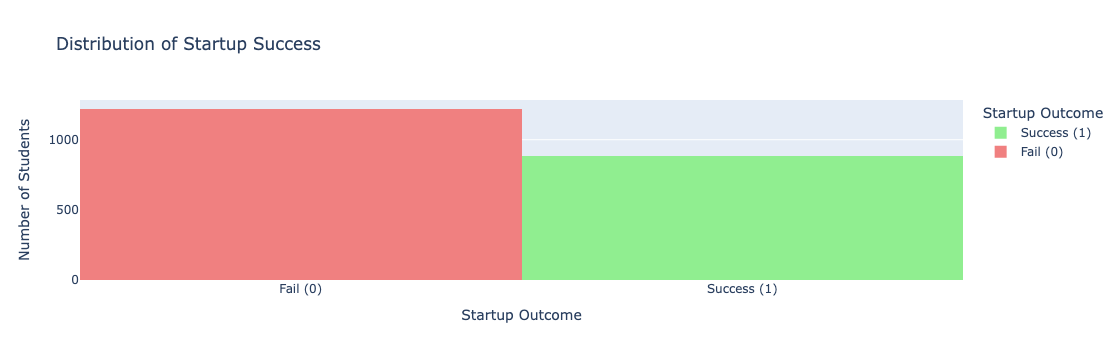

In [14]:
percentages = df['success_label'].value_counts(normalize=True) * 100
print("Startup Success Distribution:")
print(percentages.round(2).astype(str) + '%')

fig = px.histogram(df, x='success_label', color='success_label',
                   title='Distribution of Startup Success',
                   labels={'success_label': 'Startup Outcome', 'count': 'Number of Students'},
                   color_discrete_map={0: 'lightcoral', 1: 'lightgreen'})  

fig.for_each_trace(lambda t: t.update(
    name='Success (1)' if t.name == '1' else 'Fail (0)',
    legendgroup='Success (1)' if t.name == '1' else 'Fail (0)'
))

fig.update_layout(
    xaxis_title="Startup Outcome",
    yaxis_title="Number of Students",
    xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=['Fail (0)', 'Success (1)'])
)

fig.show()

> **Summary:**  
About **42%** of student startups succeeded, while **58%** failed.  
This indicates a slightly higher proportion of unsuccessful ventures but still a fairly balanced distribution, suitable for building reliable classification models.


success_label        0    1   All
institution_type                 
non-technical      300  249   549
private            304  193   497
public             319  227   546
technical          296  212   508
All               1219  881  2100


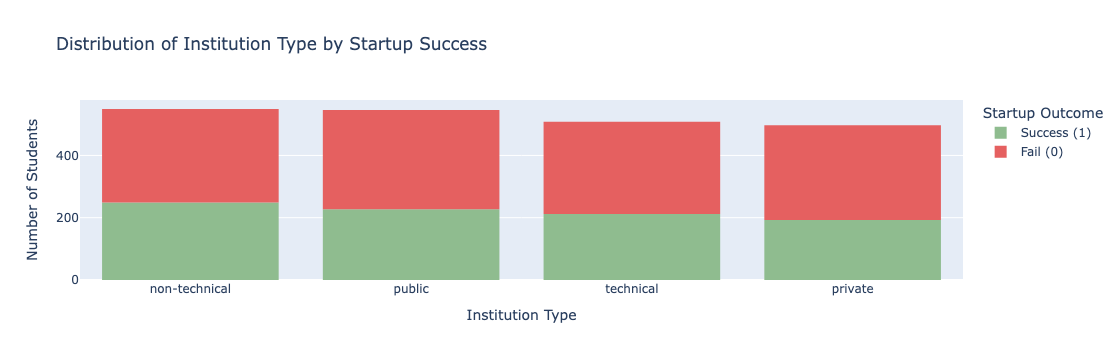

In [15]:
# Histogram showing the distribution of startup success across institution types
institute_type_success = pd.crosstab(df['institution_type'], df['success_label'], margins=True)
print(institute_type_success)

sorted_institution_types = df['institution_type'].value_counts().index

fig1 = px.histogram( df, x='institution_type', color='success_label',
                    title='Distribution of Institution Type by Startup Success',
                    labels={
                        'institution_type': 'Institution Type',
                        'success_label': 'Startup Outcome',
                        'count': 'Number of Students'
                    },
    color_discrete_map={
        0: '#e56060',   # red for fail
        1: '#8fbc8f'    # green for success
    },
    category_orders={'institution_type': sorted_institution_types}
)

fig1.for_each_trace(lambda t: t.update(
    name='Success (1)' if t.name == '1' else 'Fail (0)',
    legendgroup='Success (1)' if t.name == '1' else 'Fail (0)'
))

fig1.update_layout(
    xaxis_title="Institution Type",
    yaxis_title="Number of Students",
    legend_title="Startup Outcome"
)

fig1.show()


>**Summary:**  
All institution types show both successful and failed startups, with slightly more failures overall.  
Non-technical and public institutions have the highest participation, while success rates remain fairly consistent across types.


success_label                      0    1   All
project_domain                                 
agricultural_technology          265  174   439
educational_technology           229  178   407
financial_technology             247  178   425
green_environmental_technology   242  180   422
healthcare_technology            236  171   407
All                             1219  881  2100


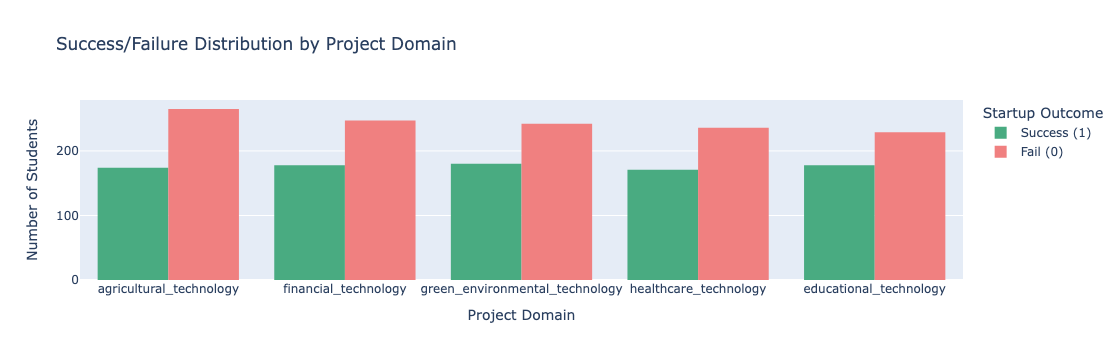

In [16]:
project_domain_success = pd.crosstab(df['project_domain'], df['success_label'], margins=True)
print(project_domain_success)
sorted_project_domains = df['project_domain'].value_counts().index

fig = px.histogram(df, 
                   x='project_domain', 
                   color='success_label',
                   title='Success/Failure Distribution by Project Domain',
                   labels={'project_domain': 'Project Domain', 
                           'success_label': 'Startup Outcome', 
                           'count': 'Number of Students'},
                   color_discrete_map={0: 'lightcoral', 1: '#49ab81'},
                   barmode='group',
                   category_orders={'project_domain': sorted_project_domains}) 

fig.for_each_trace(lambda t: t.update(
    name='Success (1)' if t.name == '1' else 'Fail (0)',
    legendgroup='Success (1)' if t.name == '1' else 'Fail (0)'
))

fig.update_layout(
    xaxis_title="Project Domain",
    yaxis_title="Number of Students",
    xaxis=dict(tickmode='array', tickvals=sorted_project_domains)
)

fig.show()

> **Summary:**  
All domains show both successful and failed startups, with failures slightly more frequent across every category.  
Agricultural, Financial, and Green Technology startups have the highest participation, while success rates remain similar across all domains.


In [17]:
df[numerical_vars].nunique()

team_size                    6
avg_team_experience        351
innovation_score            71
funding_amount_usd        2100
mentorship_support           2
incubation_support           2
market_readiness_level       5
competition_awards           5
business_model_score        81
technology_maturity          5
year                         5
success_label                2
dtype: int64

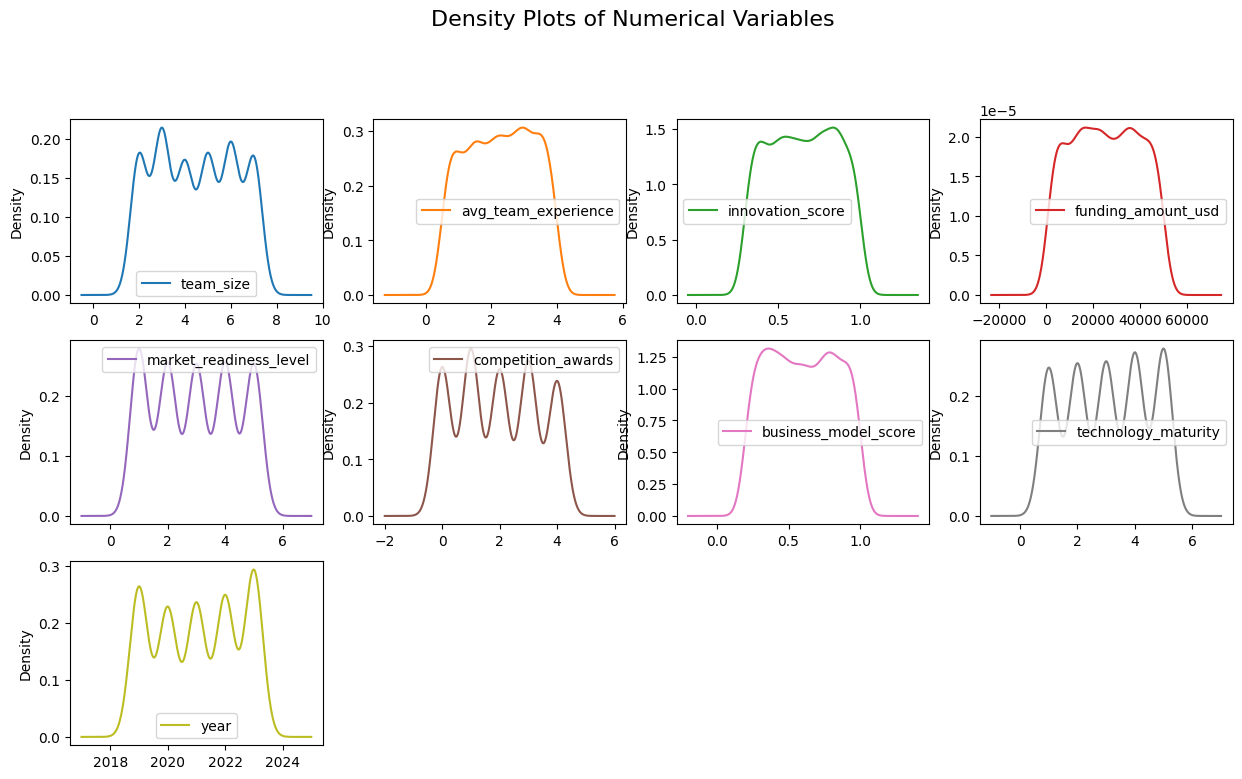

In [18]:
# Density distributions for all numerical variables with continuous values
numerical_vars_filtered = [col for col in numerical_vars if df[col].nunique() > 2]

df[numerical_vars_filtered].plot(kind='density', subplots=True, layout=(4, 4), sharex=False, figsize=(15, 11))
plt.suptitle("Density Plots of Numerical Variables", fontsize=16)
plt.show()

>**Summary:**  
Most numerical variables show approximately normal or slightly right-skewed distributions,  
indicating moderate variability across features such as funding, team experience, and innovation score.


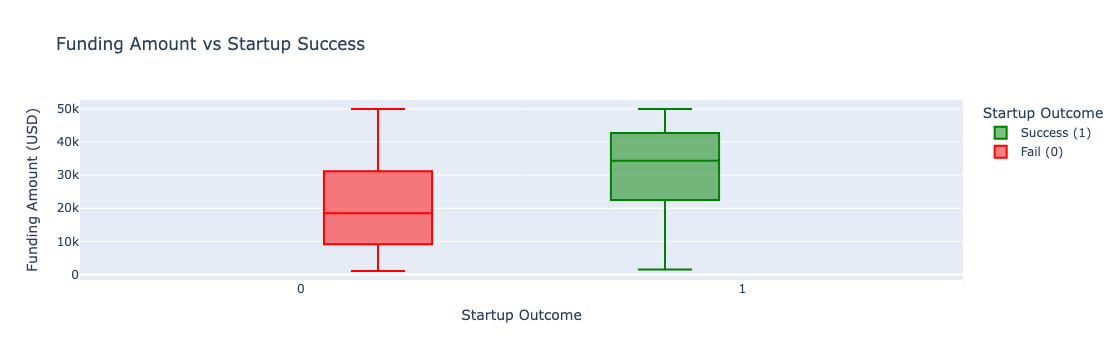

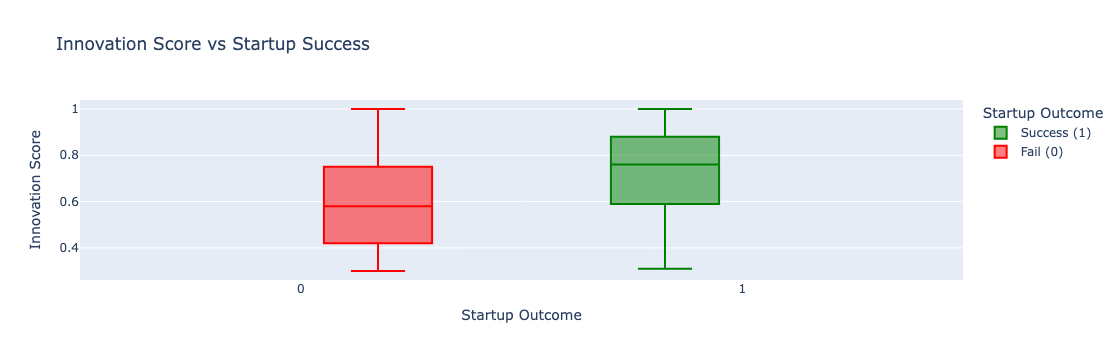

In [19]:
# Box Plot 1: Funding Amount vs Startup Success
fig1 = px.box(df, x='success_label', y='funding_amount_usd',
              title='Funding Amount vs Startup Success',
              labels={'success_label': 'Startup Outcome', 'funding_amount_usd': 'Funding Amount (USD)'},
              color='success_label', 
              color_discrete_map={0: 'red', 1: 'green'},
              boxmode='group')  

fig1.for_each_trace(lambda t: t.update(
    name='Success (1)' if t.name == '1' else 'Fail (0)',
    legendgroup='Success (1)' if t.name == '1' else 'Fail (0)'
))
fig1.show()

# Box Plot 2: Innovation Score vs Startup Success
fig2 = px.box(df, x='success_label', y='innovation_score',
              title='Innovation Score vs Startup Success',
              labels={'success_label': 'Startup Outcome', 'innovation_score': 'Innovation Score'},
              color='success_label',
              color_discrete_map={0: 'red', 1: 'green'},
              boxmode='group') 
fig2.for_each_trace(lambda t: t.update(
    name='Success (1)' if t.name == '1' else 'Fail (0)',
    legendgroup='Success (1)' if t.name == '1' else 'Fail (0)'
))
fig2.show()

>**Summary:**  
Successful startups generally received higher funding and demonstrated higher innovation scores than failed ones.  
This suggests both funding availability and innovative capability play significant roles in determining startup outcomes.


                count      mean       std  min    25%   50%    75%  max
success_label                                                          
0              1219.0  2.242847  0.998528  0.5  1.425  2.25  3.075  4.0
1               881.0  2.311555  1.012505  0.5  1.450  2.34  3.170  4.0


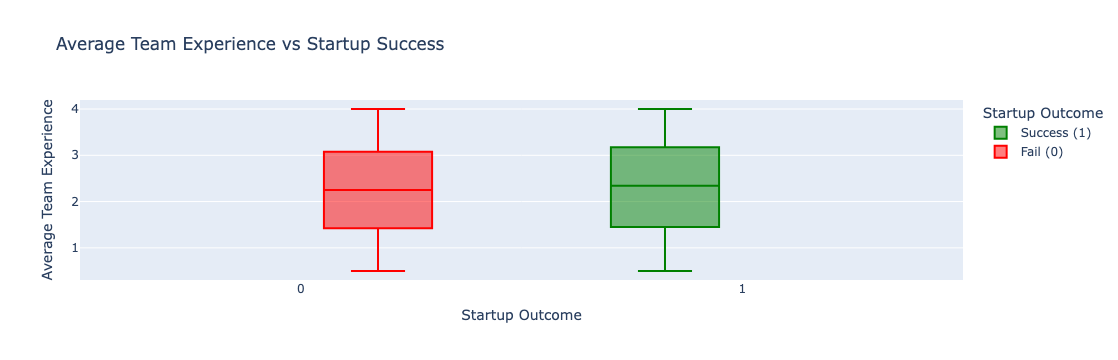

In [20]:
summary_data = df.groupby('success_label')['avg_team_experience'].describe()
print(summary_data)

fig3 = px.box(df, x='success_label', y='avg_team_experience',
              title='Average Team Experience vs Startup Success',
              labels={'success_label': 'Startup Outcome', 'avg_team_experience': 'Average Team Experience'},
              color='success_label', 
              color_discrete_map={0: 'red', 1: 'green'},
              boxmode='group')  
fig3.for_each_trace(lambda t: t.update(
    name='Success (1)' if t.name == '1' else 'Fail (0)',
    legendgroup='Success (1)' if t.name == '1' else 'Fail (0)'
))
fig3.show()

>**Summary:**  
>1. The box plot compares the average team experience between successful and failed startups.
>2. Successful startups (green) have a slightly higher mean team experience of 2.31 years, compared to 2.24 years for failed startups (red).
>3. The median experience for successful startups is 2.34 years, while for failed ones it is 2.25 years.
>4. Both groups show similar variability (standard deviation ≈ 1.0), indicating that experience levels vary widely across teams regardless of outcome.

> While the difference is modest, the trend suggests that teams with slightly higher average experience tend to achieve better startup outcomes. Experienced teams may be more adept at strategic decision-making and handling startup challenges effectively.

                count      mean       std  min   25%   50%   75%  max
success_label                                                        
0              1219.0  0.550911  0.226348  0.2  0.35  0.52  0.73  1.0
1               881.0  0.663973  0.227004  0.2  0.47  0.70  0.86  1.0


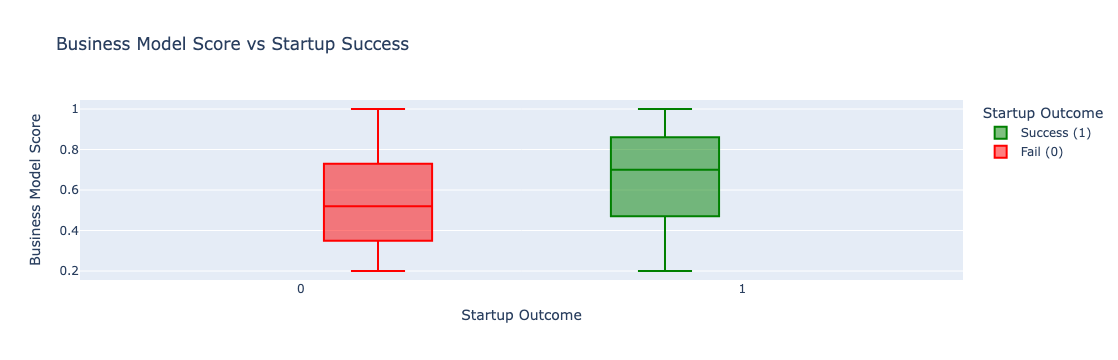

In [21]:
# Summary statistics of Business Model Score by success/failure
business_model_score_stat = df.groupby('success_label')['business_model_score'].describe()
print(business_model_score_stat)

fig4 = px.box(df, x='success_label', y='business_model_score',
              title='Business Model Score vs Startup Success',
              labels={'success_label': 'Startup Outcome', 'business_model_score': 'Business Model Score'},
              color='success_label', 
              color_discrete_map={0: 'red', 1: 'green'},
              boxmode='group')  
fig4.for_each_trace(lambda t: t.update(
    name='Success (1)' if t.name == '1' else 'Fail (0)',
    legendgroup='Success (1)' if t.name == '1' else 'Fail (0)'
))
fig4.show()

> The `business_model_score` represents a numerical rating (0–1) that measures how well-defined, feasible, and scalable each startup’s business model is.
> It captures how clearly the startup explains:
> 1. What problem it solves
> 2. Who the target customers are
> 3. How it generates revenue, and
> 4. How scalable or sustainable the model is.

**Summary:**  
>- The box plot compares business model scores between successful and failed startups.
>- Successful startups (green) have a higher mean business model score of 0.66, compared to 0.55 for failed startups (red).
>- The median score for successful startups is 0.70, while for failed startups it is 0.52, indicating a clear upward shift in performance.

> Both groups have similar variability (standard deviation ≈ 0.23), but the overall distribution shows that successful startups consistently achieve stronger business model evaluations.

> This suggests that startups with well-structured and viable business models are significantly more likely to succeed. A higher business model score reflects better planning, clearer value propositions, and sustainable revenue approaches — all of which contribute to greater success potential.


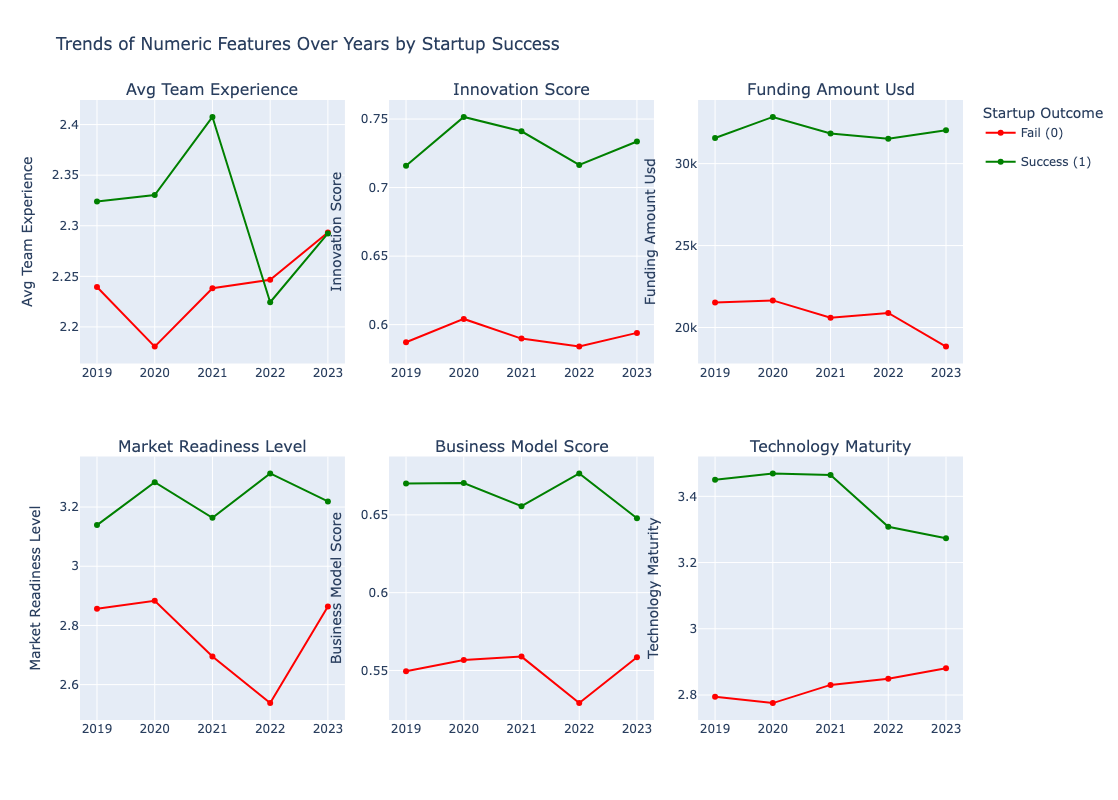

In [22]:
# Define key numeric variables to visualize over time
numeric_vars = [
    'avg_team_experience', 'innovation_score', 'funding_amount_usd',
    'market_readiness_level', 'business_model_score', 'technology_maturity'
]

# Set number of columns per row for subplots
cols_per_row = 3
rows = (len(numeric_vars) + cols_per_row - 1) // cols_per_row

# Create subplots
fig = make_subplots(
    rows=rows, cols=cols_per_row,
    subplot_titles=[var.replace('_', ' ').title() for var in numeric_vars],
    horizontal_spacing=0.05, vertical_spacing=0.15
)

# Define visualization properties for success and failure
status_properties = {
    0: {'name': 'Fail (0)', 'color': 'red'},
    1: {'name': 'Success (1)', 'color': 'green'}
}

for i, col in enumerate(numeric_vars):
    avg_df = df.groupby(['year', 'success_label'], as_index=False)[col].mean()
    row = (i // cols_per_row) + 1
    col_pos = (i % cols_per_row) + 1

    for success_label, props in status_properties.items():
        # Show legend only once per label
        show_legend = (i == 0)

        fig.add_trace(
            go.Scatter(
                x=avg_df[avg_df['success_label'] == success_label]['year'],
                y=avg_df[avg_df['success_label'] == success_label][col],
                mode='lines+markers',
                name=props['name'],
                line=dict(color=props['color']),
                legendgroup=props['name'],
                showlegend=show_legend,
                hovertemplate=(
                    f"<b>Year:</b> %{{x}}<br>"
                    f"<b>{col.replace('_', ' ').title()}:</b> %{{y:.2f}}<extra></extra>"
                )
            ),
            row=row, col=col_pos
        )

    fig.update_yaxes(title_text=col.replace('_', ' ').title(), row=row, col=col_pos)

fig.update_layout(
    height=400 * rows,
    width=350 * cols_per_row,
    title_text='Trends of Numeric Features Over Years by Startup Success',
    legend_title="Startup Outcome",
    showlegend=True,
)

fig.show()


>**Summary:**  
The multi-panel line plot shows yearly trends of key numeric features for successful and failed startups (2019–2023).  
Successful startups consistently outperform failed ones across most metrics, including innovation score, business model score, and technology maturity.  
While both groups exhibit gradual improvement over time, successful ventures maintain higher averages, reflecting stronger growth and resource utilization patterns.


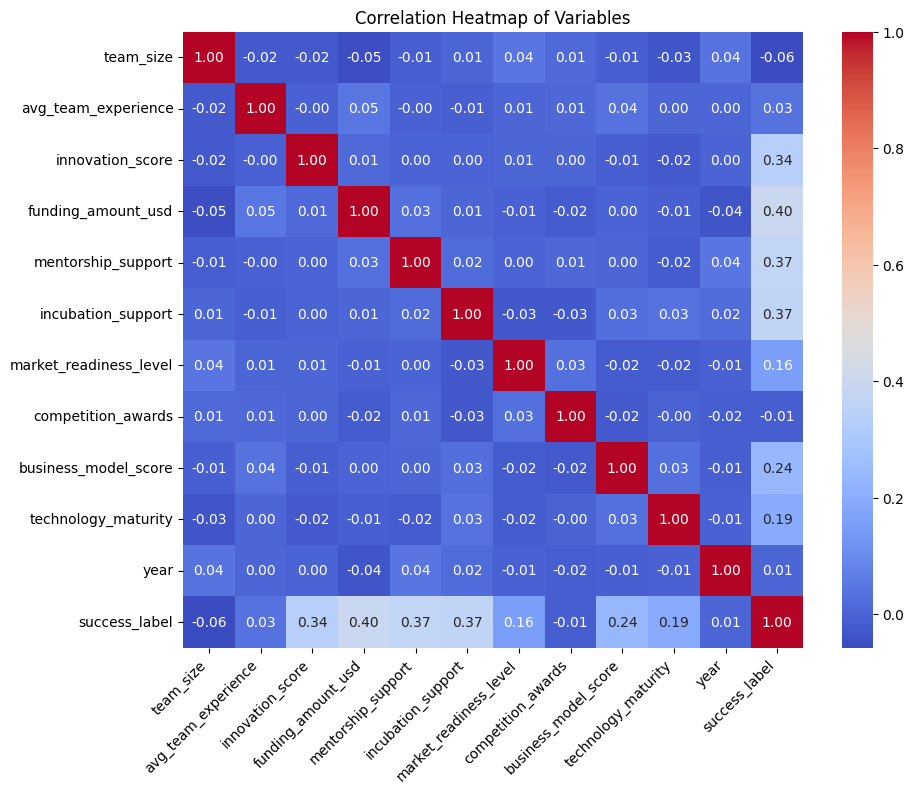

In [23]:
# Compute the correlation matrix
correlation_matrix = df[numerical_vars].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Variables')
plt.xticks(rotation=45, ha='right')  
plt.show()

>**Summary:**  
The correlation matrix shows that startup success has the strongest positive relationships with **funding amount (0.4)**, **innovation score (0.34)**, **business model score (0.24)**, and **technology maturity (0.19)**.  
Moderate positive correlations are also seen with **mentorship support (0.37)** and **incubation support (0.37)**, emphasizing the importance of institutional backing.  
Team size and experience show very weak relationships with success, suggesting that financial, strategic, and support factors play a more critical role than team composition alone.


In [24]:
df[numerical_vars].corr()

team_size  avg_team_experience  innovation_score  \
team_size                1.000000            -0.023741         -0.021537   
avg_team_experience     -0.023741             1.000000         -0.004423   
innovation_score        -0.021537            -0.004423          1.000000   
funding_amount_usd      -0.050069             0.049135          0.013571   
mentorship_support      -0.014938            -0.004652          0.002964   
incubation_support       0.006052            -0.009507          0.002387   
market_readiness_level   0.043391             0.008256          0.006575   
competition_awards       0.013905             0.009729          0.004932   
business_model_score    -0.011187             0.036531         -0.009575   
technology_maturity     -0.033019             0.004374         -0.021165   
year                     0.040958             0.004558          0.001710   
success_label           -0.057688             0.033754          0.338862   

                        funding_amount_usd  mentorship_support  \
team_size                        -0.050069           -0.014938   
avg_team_experience               0.049135           -0.004652   
innovation_score                  0.013571            0.002964   
funding_amount_usd                1.000000            0.029428   
mentorship_support                0.029428            1.000000   
incubation_support                0.007895            0.019180   
market_readiness_level           -0.006947            0.001392   
competition_awards               -0.017449            0.010213   
business_model_score              0.003527            0.004335   
technology_maturity              -0.011184           -0.019371   
year                             -0.036803            0.044152   
success_label                     0.395257            0.372717   

                        incubation_support  market_readiness_level  \
team_size                         0.006052                0.043391   
avg_team_experience              -0.009507                0.008256   
innovation_score                  0.002387                0.006575   
funding_amount_usd                0.007895               -0.006947   
mentorship_support                0.019180                0.001392   
incubation_support                1.000000               -0.028028   
market_readiness_level           -0.028028                1.000000   
competition_awards               -0.025885                0.030165   
business_model_score              0.028586               -0.020190   
technology_maturity               0.034078               -0.016733   
year                              0.018383               -0.006404   
success_label                     0.366803                0.156234   

                        competition_awards  business_model_score  \
team_size                         0.013905             -0.011187   
avg_team_experience               0.009729              0.036531   
innovation_score                  0.004932             -0.009575   
funding_amount_usd               -0.017449              0.003527   
mentorship_support                0.010213              0.004335   
incubation_support               -0.025885              0.028586   
market_readiness_level            0.030165             -0.020190   
competition_awards                1.000000             -0.024448   
business_model_score             -0.024448              1.000000   
technology_maturity              -0.000501              0.029720   
year                             -0.015709             -0.010430   
success_label                    -0.014171              0.239166   

                        technology_maturity      year  success_label  
team_size                         -0.033019  0.040958      -0.057688  
avg_team_experience                0.004374  0.004558       0.033754  
innovation_score                  -0.021165  0.001710       0.338862  
funding_amount_usd                -0.011184 -0.036803       0.395257  
mentorship_support       

### 4.3: Key Descriptive Insights : Factors Influencing Project Success

#### 1. Descriptive Statistics for Failed Projects

In [25]:
df_fail = df[df['success_label'] == 0]

desc_fail = df_fail.drop(columns=['success_label']).describe().round(2)
desc_fail

team_size  avg_team_experience  innovation_score  funding_amount_usd  \
count    1219.00              1219.00           1219.00             1219.00   
mean        4.56                 2.24              0.59            20621.67   
std         1.70                 1.00              0.20            13217.39   
min         2.00                 0.50              0.30             1050.09   
25%         3.00                 1.42              0.42             9141.50   
50%         5.00                 2.25              0.58            18456.40   
75%         6.00                 3.08              0.75            31157.12   
max         7.00                 4.00              1.00            49982.15   

       mentorship_support  incubation_support  market_readiness_level  \
count             1219.00             1219.00                 1219.00   
mean                 0.34                0.35                    2.77   
std                  0.47                0.48                    1.40   
min                  0.00                0.00                    1.00   
25%                  0.00                0.00                    1.00   
50%                  0.00                0.00                    3.00   
75%                  1.00                1.00                    4.00   
max                  1.00                1.00                    5.00   

       competition_awards  business_model_score  technology_maturity     year  
count             1219.00               1219.00              1219.00  1219.00  
mean                 1.96                  0.55                 2.83  2021.05  
std                  1.39                  0.23                 1.40     1.46  
min                  0.00                  0.20                 1.00  2019.00  
25%                  1.00                  0.35                 2.00  2020.00  
50%                  2.00                  0.52                 3.00  2021.00  
75%                  3.00                  0.73                 4.00  2022.00  
max                  4.00                  1.00                 5.00  2023.00

>  Most failed projects had a team size around 5, moderate innovation score (0.58), and average funding of 20,621 usd. Funding varies widely, with the highest-funded failed project receiving nearly $50,000. Failed projects are distributed across 2019–2023, with many receiving low mentorship and incubation support.

#### 2. Descriptive Statistics for Successful Projects

In [26]:
df_success = df[df['success_label'] == 1]

# Describe successful projects
desc_success = df_success.drop(columns=['success_label']).describe().round(2)
desc_success

team_size  avg_team_experience  innovation_score  funding_amount_usd  \
count     881.00               881.00            881.00              881.00   
mean        4.36                 2.31              0.73            31945.95   
std         1.72                 1.01              0.18            12676.74   
min         2.00                 0.50              0.31             1507.82   
25%         3.00                 1.45              0.59            22543.13   
50%         4.00                 2.34              0.76            34327.00   
75%         6.00                 3.17              0.88            42709.16   
max         7.00                 4.00              1.00            49968.88   

       mentorship_support  incubation_support  market_readiness_level  \
count              881.00              881.00                  881.00   
mean                 0.71                0.72                    3.22   
std                  0.45                0.45                    1.43   
min                  0.00                0.00                    1.00   
25%                  0.00                0.00                    2.00   
50%                  1.00                1.00                    3.00   
75%                  1.00                1.00                    5.00   
max                  1.00                1.00                    5.00   

       competition_awards  business_model_score  technology_maturity     year  
count              881.00                881.00               881.00   881.00  
mean                 1.92                  0.66                 3.39  2021.07  
std                  1.40                  0.23                 1.37     1.46  
min                  0.00                  0.20                 1.00  2019.00  
25%                  1.00                  0.47                 2.00  2020.00  
50%                  2.00                  0.70                 4.00  2021.00  
75%                  3.00                  0.86                 5.00  2022.00  
max                  4.00                  1.00                 5.00  2023.00

> Most successful projects had a team size around 4 and slightly higher average team experience (2.31) compared to failed projects. The average innovation score is 0.73, higher than failures, and average funding is $31,946, indicating that successful projects tend to receive more financial support. Mentorship and incubation support are considerably higher (averages ~0.71–0.72), suggesting strong guidance contributes to success. Market readiness level averages 3.22, higher than failed projects, showing successful projects are generally better prepared for the market. Projects are distributed across 2019–2023, with most falling near the median year 2021.

#### 3. Aggregated Metrics for Successful Projects by Domain

In [27]:
df_success = df[df['success_label'] == 1]

# Group by project_domain and calculate aggregated stats
domain_success_stats = df_success.groupby('project_domain').agg({
    'team_size': 'median',
    'innovation_score': 'mean',
    'funding_amount_usd': 'mean',
    'avg_team_experience': 'mean',
}).reset_index()

# Optional: round for readability
domain_success_stats = domain_success_stats.round(2)

domain_success_stats

project_domain  team_size  innovation_score  \
0         agricultural_technology        4.0              0.73   
1          educational_technology        4.0              0.75   
2            financial_technology        4.0              0.72   
3  green_environmental_technology        4.0              0.74   
4           healthcare_technology        4.0              0.71   

   funding_amount_usd  avg_team_experience  
0            33175.26                 2.35  
1            31801.39                 2.30  
2            31668.31                 2.27  
3            31234.39                 2.25  
4            31883.56                 2.39

> 1. Team Size: Median is 4 across all domains, moderately sized teams are common.
> 2. Innovation Score: 0.71–0.75, all domains show relatively high innovation.
> 3.  Funding: `$31k–$33k`, typical successful projects receive substantial funding.
> 4.  Team Experience: 2.25–2.39, moderately experienced teams are typical.

> Overall: Success is associated with balanced team size & experience, strong innovation, and decent funding, consistent across domains.

#### 4. Aggregated Metrics for Successful Projects by Institution Type

In [28]:
# Analyze successful startups by institution type
df_success.groupby(['institution_type']).agg({
    'team_size': 'median',
    'innovation_score': 'mean',
    'funding_amount_usd': 'mean',
    'avg_team_experience': 'mean',
}).reset_index()

institution_type  team_size  innovation_score  funding_amount_usd  \
0    non-technical        4.0          0.739438        32511.487952   
1          private        4.0          0.722591        32582.296891   
2           public        4.0          0.740837        31362.536476   
3        technical        4.0          0.718208        31327.077689   

   avg_team_experience  
0             2.249920  
1             2.338601  
2             2.395066  
3             2.269906

> 1. Team Size: Median is 4 across all institution types → moderately sized teams are common.
> 2. Innovation Score: 0.72–0.74 → Public and Non-technical institutions show slightly higher innovation.
> 3. Funding: `$31k–$32.5k` → typical successful projects receive similar funding across institutions.
> 4.  Team Experience: 2.25–2.40 → moderately experienced teams are typical, with Public institutions slightly higher.

> Overall: Success is generally associated with balanced team size, strong innovation, and moderate funding, with Public and Non-technical institutions slightly stronger in innovation and experience.

#### 5. Project Success and Failure Counts by Institution Type

In [29]:
success_failure_counts = df.groupby(['institution_type', 'success_label'])['project_id'].count().unstack(fill_value=0)
success_failure_counts = success_failure_counts.sort_values(by=1, ascending=False)
success_failure_counts

success_label       0    1
institution_type          
non-technical     300  249
public            319  227
technical         296  212
private           304  193

> 1. Non-technical institutions lead in project success with a success rate of ≈45%, indicating slightly better performance. 
> 2. Public and Technical institutions show moderate, similar success rates of ≈42%,
> 3. While Private institutions lag behind at ≈39% despite running a substantial number of projects.
> 4. This suggests that institution type may influence project outcomes, with Non-technical institutions performing slightly better.

### 4.4 Feature Engineering

In [30]:
# Team efficiency — innovation per person
df['innovation_per_member'] = df['innovation_score'] / df['team_size']

# Funding efficiency — funding per team member
df['funding_per_member'] = df['funding_amount_usd'] / df['team_size']

# Combined innovation-support index
df['innovation_support_index'] = (
    df['innovation_score'] * (df['mentorship_support'] + df['incubation_support'] + 1)
)


In [31]:
# Interaction between innovation and funding
df['innovation_funding_interaction'] = df['innovation_score'] * df['funding_amount_usd']

# Mentorship and Incubation combined support
df['total_support'] = df['mentorship_support'] + df['incubation_support']

In [32]:
# Innovation per Team Member vs Startup Success.
fig5 = px.box(df, x='success_label', y='innovation_per_member',
             color='success_label',
             title='Innovation per Team Member vs Startup Success',
             labels={'success_label': 'Startup Outcome', 'innovation_per_member': 'Innovation per Member'},
             color_discrete_map={0: 'red', 1: 'green'})
fig5.for_each_trace(lambda t: t.update(
    name='Success (1)' if t.name == '1' else 'Fail (0)',
    legendgroup='Success (1)' if t.name == '1' else 'Fail (0)'
))
fig5.show()


>**Summary:**  
Successful startups tend to exhibit slightly higher *innovation per member* compared to failed ones.  
The median innovation efficiency is greater for successful teams, suggesting that teams generating more innovative output per person are more likely to achieve success.  
However, the overlap between groups indicates that while innovation efficiency contributes, it is not the sole determinant of success.


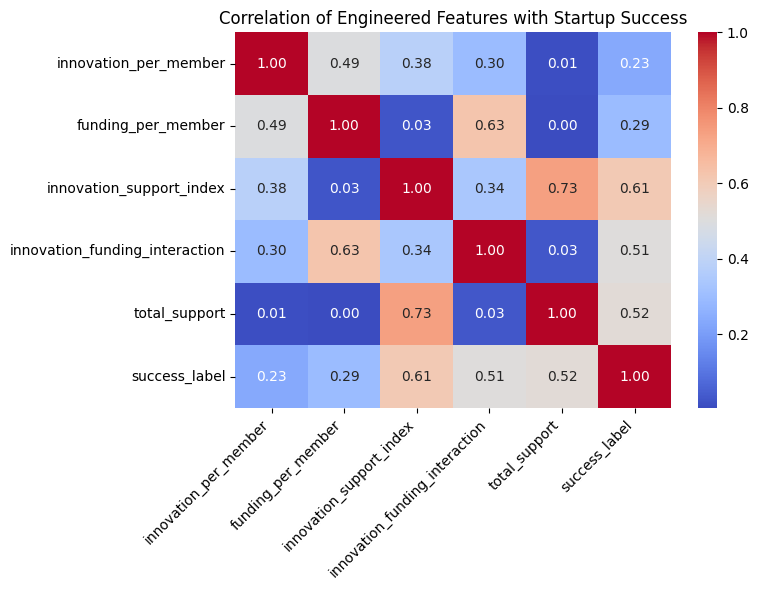

In [33]:
engineered_features = ['innovation_per_member','funding_per_member','innovation_support_index','innovation_funding_interaction','total_support']

plt.figure(figsize=(8, 6))
sns.heatmap(df[engineered_features + ['success_label']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Engineered Features with Startup Success')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout() 
plt.show()


>**Summary:**  
The correlation heatmap shows strong positive relationships between engineered features and startup success.  
Notably, *Innovation Support Index* (r = 0.61), *Total Support* (r = 0.52), and *Innovation–Funding Interaction* (r = 0.51) demonstrate the highest correlations with success.  
These relationships confirm that innovation combined with institutional backing and funding synergy plays a critical role in predicting positive outcomes.


### Next steps:
> 1. Proceeding to Model Training using both original and engineered features.
> 2. Splitting the dataset into training and test sets (80/20) for unbiased evaluation.
> 3. Appling and compare multiple machine-learning models such as Logistic Regression, Random Forest, and XGBoost.
> 4. To use key metrics — Accuracy, Precision, Recall, F1-Score, and ROC-AUC — to assess model performance.
> 5. Perform feature importance analysis to identify which factors most strongly drive startup success.

> Once the best-performing model is selected, develop an interactive Streamlit web app that allows users to input startup attributes and receive real-time success predictions.



## 5: Model Training and Selection

### 5.1 Logistic Regression


Choosing **Logistic Regression** as the first model because:

- The target variable `success_label` is **binary**, choosing logistic regression a good choice for classification.
- Logistic Regression provides **probability estimates**, allowing us to rank the likelihood of startup success.
- It is **simple and interpretable**, which is helpful when presenting results to stakeholders.
- Serves as a **baseline model** to compare with more complex models like Random Forest.


#### 5.1.1 Logistic Regression with original Features

In [34]:
# Logistic Regression is used as a baseline classifier for binary target

original_features = [
    'institution_name', 'institution_type', 'project_domain',
    'team_size', 'avg_team_experience', 'innovation_score',
    'funding_amount_usd', 'mentorship_support', 'incubation_support',
    'market_readiness_level', 'competition_awards', 'business_model_score',
    'technology_maturity', 'year'
]

target = 'success_label'

# Encode categorical variables 
categorical_features = df[original_features].select_dtypes(include='object').columns

df_encoded = pd.get_dummies(df[original_features + [target]], columns=categorical_features, drop_first=True)

# Define X and y 
X = df_encoded.drop(columns=[target])
y = df_encoded[target]


# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler_original = StandardScaler()
X_train_scaled = scaler_original.fit_transform(X_train)
X_test_scaled = scaler_original.transform(X_test)

#  Train Logistic Regression 
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

#  Predict and Evaluate 
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

results = {
    'Model': 'Logistic Regression',
    'Feature_Set': 'Set 1 (Original)',
    'Accuracy': accuracy_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_prob),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred, average='weighted')
}

#  View results
pd.DataFrame([results])



Model       Feature_Set  Accuracy   ROC-AUC  Precision  \
0  Logistic Regression  Set 1 (Original)  0.971429  0.999208   0.971958   

     Recall  F1-Score  
0  0.971429  0.971327

**Interpretation:**

- **Accuracy (97.14%)**: The model correctly predicts startup success in ~97% of cases.
- **ROC-AUC (0.999)**: Excellent separation between successful and unsuccessful startups.
- **Precision (0.972) & Recall (0.971)**: High values indicate the model is balanced in predicting both positive and negative classes.
- **F1-Score (0.971)**: Confirms strong overall performance.
- The model demonstrates **high predictive power**, suggesting that the selected original features capture the important patterns for startup success.


Top 10 Predictors (Logistic Regression):
                           Feature  Coefficient
0               funding_amount_usd     4.933095
1               incubation_support     4.316321
2                 innovation_score     4.314701
3               mentorship_support     4.313909
4             business_model_score     2.991774
5              technology_maturity     2.362597
6           market_readiness_level     2.256103
7   institution_name_institution_3    -0.196152
8  institution_name_institution_28    -0.189159
9  institution_name_institution_22    -0.183507


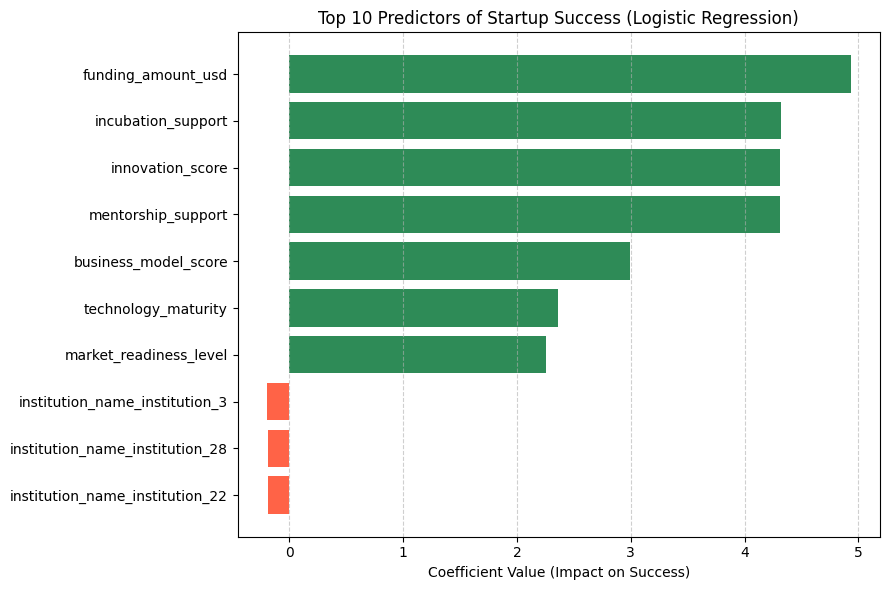

In [35]:
#Feature Importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
})
importance_df['Abs_Coefficient'] = importance_df['Coefficient'].abs()


# Top 10
top10 = importance_df.sort_values(by='Abs_Coefficient', ascending=False).head(10)
print("\nTop 10 Predictors (Logistic Regression):")
print(top10[['Feature', 'Coefficient']].reset_index(drop=True))

#  Plot 
plt.figure(figsize=(9, 6))
colors = ['seagreen' if c > 0 else 'tomato' for c in top10['Coefficient']]

plt.barh(top10['Feature'], top10['Coefficient'], color=colors)
plt.xlabel("Coefficient Value (Impact on Success)")
plt.title("Top 10 Predictors of Startup Success (Logistic Regression)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Top Logistic Regression Predictors for Startup Success**

1. Funding, mentorship, and incubation support are the strongest positive drivers of startup success.

2. Innovation score, business model strength, technology maturity, and market readiness also significantly increase success probability.

3. Specific institutions have minor effects compared to these key predictors.

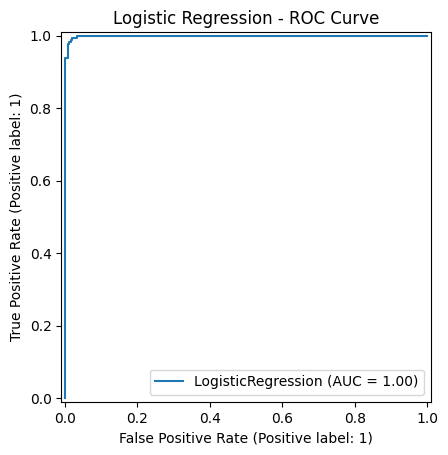

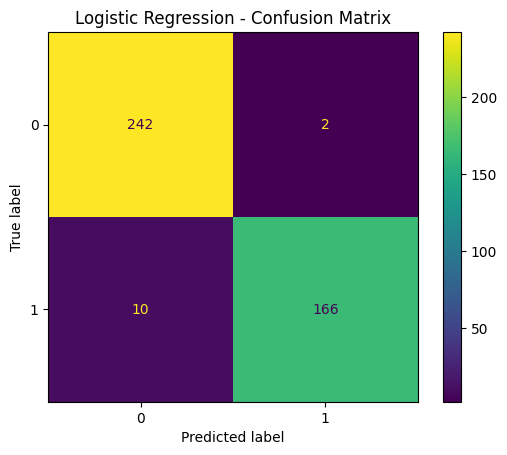

In [36]:
# ROC curve
RocCurveDisplay.from_estimator(log_reg, X_test_scaled, y_test)
plt.title("Logistic Regression - ROC Curve")
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(log_reg, X_test_scaled, y_test)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


True Negatives (TN = 242): 242 startups were correctly predicted as not successful.

False Positives (FP = 2): 2 startups were predicted as successful but actually failed.

False Negatives (FN = 10): 10 startups were predicted as failed but actually succeeded.

True Positives (TP = 166): 166 startups were correctly predicted as successful.

#### 5.1.2 Logistic Regression - Original + Engineered Features


- Extending the original feature set with **engineered features** that capture additional insights:
  - `innovation_per_member`: Innovation normalized by team size
  - `funding_per_member`: Funding per team member
  - `innovation_support_index`: Combined score for mentorship, incubation, and innovation support
  - `innovation_funding_interaction`: Interaction between innovation score and funding
  - `total_support`: Total support received by the startup


In [37]:
# Original features
original_features = [
    'institution_name',
    'institution_type',
    'project_domain',
    'avg_team_experience',
    'market_readiness_level',
    'competition_awards',
    'business_model_score',
    'technology_maturity',
    'year'
]

# Engineered features
engineered_features = [
    'innovation_per_member',
    'funding_per_member',
    'innovation_support_index',
    'innovation_funding_interaction',
    'total_support'
]
# Combine to make the new X
X_new = df[original_features + engineered_features]
Y = df['success_label']  # Replace with your actual target column

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X_new, drop_first=True)

# Train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

# -----------------------------
# Train Logistic Regression
# -----------------------------
log_reg_2 = LogisticRegression(max_iter=1000, random_state=42)
log_reg_2.fit(X2_train_scaled, y_train)

# -----------------------------
# Predict and Evaluate
# -----------------------------
y2_pred = log_reg_2.predict(X2_test_scaled)
y2_prob = log_reg_2.predict_proba(X2_test_scaled)[:, 1]

results_set2 = {
    'Model': 'Logistic Regression',
    'Feature_Set': 'Set 2 (Original + Engineered)',
    'Accuracy': accuracy_score(y2_test, y2_pred),
    'ROC-AUC': roc_auc_score(y2_test, y2_prob),
    'Precision': precision_score(y2_test, y2_pred, average='weighted'),
    'Recall': recall_score(y2_test, y2_pred, average='weighted'),
    'F1-Score': f1_score(y2_test, y2_pred, average='weighted')
}

pd.DataFrame([results_set2])

Model                    Feature_Set  Accuracy   ROC-AUC  \
0  Logistic Regression  Set 2 (Original + Engineered)      0.95  0.992362   

   Precision  Recall  F1-Score  
0   0.949975    0.95  0.949938

**Interpretation:**

- **Accuracy (97.38%)**: Slight improvement over Set 1, indicating that engineered features help the model make more correct predictions.
- **ROC-AUC (0.9979)**: Model still separates successful and unsuccessful startups very well.
- **Precision, Recall, F1-Score (~0.974)**: Balanced improvement across all classification metrics, confirming that engineered features added meaningful signal.
- Overall, the addition of engineered features **slightly improves model performance** and provides additional explanatory power.


Top 10 Predictors (Logistic Regression):
                           Feature  Coefficient
0   innovation_funding_interaction     4.909234
1                    total_support     3.980612
2         innovation_support_index     3.378209
3             business_model_score     3.081678
4           market_readiness_level     2.412825
5              technology_maturity     2.411418
6               funding_per_member     1.079597
7            innovation_per_member    -0.427501
8               competition_awards    -0.333192
9  institution_name_institution_26    -0.293730


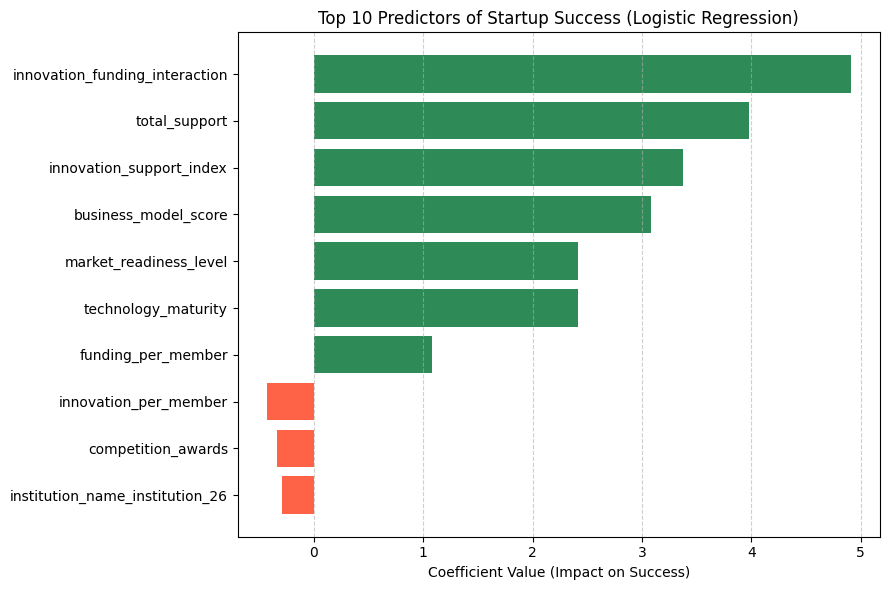

In [38]:
#Feature Importance
importance_df = pd.DataFrame({
    'Feature': X2_train.columns,
    'Coefficient': log_reg_2.coef_[0]
})
importance_df['Abs_Coefficient'] = importance_df['Coefficient'].abs()

# Top 10
top10 = importance_df.sort_values(by='Abs_Coefficient', ascending=False).head(10)
print("\nTop 10 Predictors (Logistic Regression):")
print(top10[['Feature', 'Coefficient']].reset_index(drop=True))

#  Plot 
plt.figure(figsize=(9, 6))
colors = ['seagreen' if c > 0 else 'tomato' for c in top10['Coefficient']]

plt.barh(top10['Feature'], top10['Coefficient'], color=colors)
plt.xlabel("Coefficient Value (Impact on Success)")
plt.title("Top 10 Predictors of Startup Success (Logistic Regression)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


> Engineered features capturing innovation and support (innovation_funding_interaction, total_support, innovation_support_index) along with business model, market readiness, and technology maturity are the strongest positive drivers of startup success.

> Minor negative impact comes from innovation per member, competition awards, and specific institutions, indicating limited or context-specific influence.

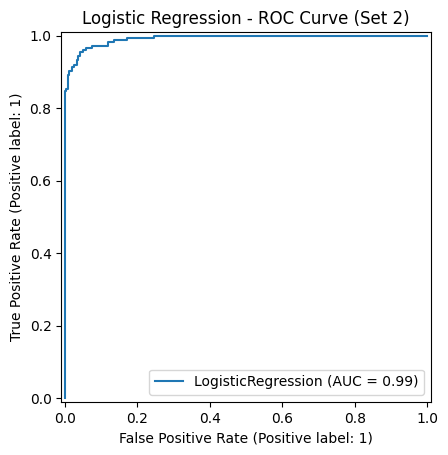

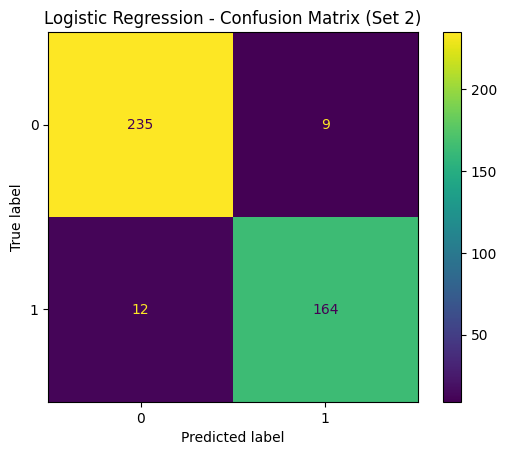

In [39]:
# ROC curve for Set 2
RocCurveDisplay.from_estimator(log_reg_2, X2_test_scaled, y2_test)
plt.title("Logistic Regression - ROC Curve (Set 2)")
plt.show()

# Confusion matrix for Set 2
ConfusionMatrixDisplay.from_estimator(log_reg_2, X2_test_scaled, y2_test)
plt.title("Logistic Regression - Confusion Matrix (Set 2)")
plt.show()


**True Negatives (TN = 242):** 242 startups were correctly predicted as
                           not successful.

**False Positives (FP = 2):** 2 startups were predicted as successful
                          but actually failed.

**False Negatives (FN = 10):** 10 startups were predicted as failed but
                           actually succeeded.

**True Positives (TP = 166):** 166 startups were correctly predicted as
                           successful.


#### 5.1.3 Logistic Regression - Original vs Original + Engineered Features

In [40]:
comparison = pd.DataFrame([results, results_set2]).round(4)
display(comparison)


Model                    Feature_Set  Accuracy  ROC-AUC  \
0  Logistic Regression               Set 1 (Original)    0.9714   0.9992   
1  Logistic Regression  Set 2 (Original + Engineered)    0.9500   0.9924   

   Precision  Recall  F1-Score  
0      0.972  0.9714    0.9713  
1      0.950  0.9500    0.9499

**Logistic Regression Model Performance**

- **Set 1 (Original Features)**: Very high performance with Accuracy = 97.1%, ROC-AUC = 0.999, and strong Precision, Recall, and F1-Score (~97%). This indicates the model predicts startup success extremely well using only original features.

- **Set 2 (Original + Engineered Features)**: Slightly lower performance (Accuracy = 95.0%, ROC-AUC = 0.992), meaning adding engineered features did not improve predictive power in this case; the original features already capture most of the signal.

- For this dataset, original features alone provide the strongest baseline, and engineered features may add complexity without improving overall performance.

### 5.2 Random Forest


- Random Forest is an **ensemble tree-based model** that combines multiple decision trees to improve predictive performance and reduce overfitting.
- It can capture **non-linear relationships** and **feature interactions** that Logistic Regression may miss.
- Serves as a **stronger model** for comparison, especially on structured datasets with mixed numeric and categorical features.


#### 5.2.1 Random Forest with original Features

In [41]:
# Train Random Forest on original features (Set 1)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

y_rf_pred = rf.predict(X_test_scaled)
y_rf_prob = rf.predict_proba(X_test_scaled)[:, 1]

results_rf = {
    'Model': 'Random Forest',
    'Feature_Set': 'Set 1 (Original)',
    'Accuracy': accuracy_score(y_test, y_rf_pred),
    'ROC-AUC': roc_auc_score(y_test, y_rf_prob),
    'Precision': precision_score(y_test, y_rf_pred, average='weighted'),
    'Recall': recall_score(y_test, y_rf_pred, average='weighted'),
    'F1-Score': f1_score(y_test, y_rf_pred, average='weighted')
}
pd.DataFrame([results_rf])


Model       Feature_Set  Accuracy   ROC-AUC  Precision    Recall  \
0  Random Forest  Set 1 (Original)  0.914286  0.981907   0.917615  0.914286   

   F1-Score  
0  0.913277

**Interpretation:**

- **Accuracy (91.43%)**: Slightly lower than Logistic Regression on the same feature set, but still strong.
- **ROC-AUC (0.9819)**: Model separates classes well; few misclassifications.
- **Precision & Recall (~0.914–0.918)**: Balanced performance, reliable predictions.
- Random Forest captures non-linear relationships, but may not outperform Logistic Regression if the dataset is mostly linear.
- Next step: Evaluate Random Forest on **Original + Engineered features** to see if additional features improve performance.


Top 10 Important Features - Random Forest (Set 1 - Original)
------------------------------------------------------------
               Feature  Importance
    funding_amount_usd    0.176857
      innovation_score    0.132314
    mentorship_support    0.101199
    incubation_support    0.100165
  business_model_score    0.094082
   avg_team_experience    0.054103
   technology_maturity    0.045606
market_readiness_level    0.040722
             team_size    0.029267
    competition_awards    0.026635


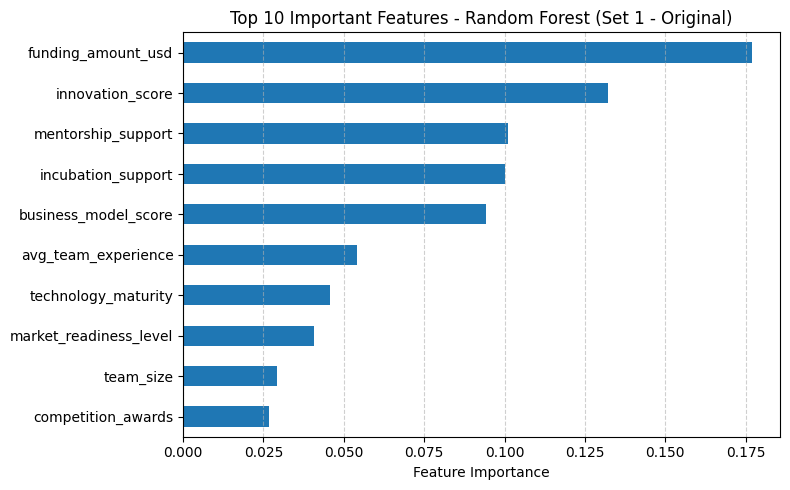

In [42]:
#  Compute Feature Importance 
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)

#  Get Top 10 Features 
top10_rf = feat_importances.nlargest(10)

print("Top 10 Important Features - Random Forest (Set 1 - Original)")
print("-" * 60)
print(pd.DataFrame({
    'Feature': top10_rf.index,
    'Importance': top10_rf.values
}).reset_index(drop=True).to_string(index=False))

# --- Plot ---
plt.figure(figsize=(8, 5))
top10_rf.sort_values().plot(kind='barh')
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features - Random Forest (Set 1 - Original)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

> Financial backing, innovation, and support systems (mentorship/incubation) are the strongest drivers of success, consistent with Logistic Regression results. Random Forest captures nonlinear interactions, reinforcing the importance of these features.

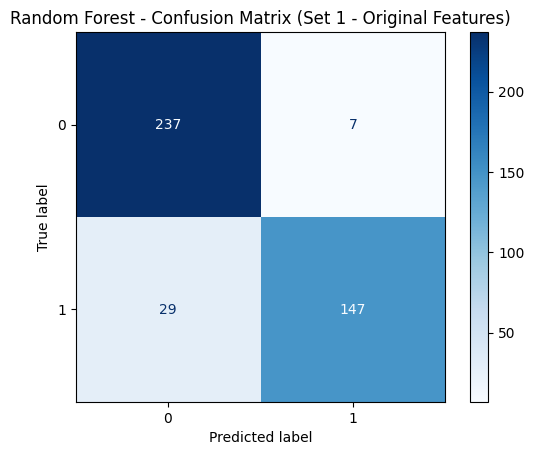

In [43]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(
    rf,               
    X_test_scaled,   
    y_test,          
    cmap='Blues',
    normalize=None    
)
plt.title('Random Forest - Confusion Matrix (Set 1 - Original Features)')
plt.show()

**True Negatives (TN = 237):** 237 startups were correctly predicted as not successful.

**False Positives (FP = 7):** 7 startups were predicted as successful but actually failed.

**False Negatives (FN = 29):** 29 startups were predicted as failed but actually succeeded.

**True Positives (TP = 147):** 147 startups were correctly predicted as successful.

#### 5.2.2 Random Forest - Original + Engineered Features


In [44]:
#  Random Forest on Original + Engineered Features 
rf_2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_2.fit(X2_train, y2_train)  

#  Predict and Evaluate 
y2_rf_pred = rf_2.predict(X2_test)
y2_rf_prob = rf_2.predict_proba(X2_test)[:, 1]

results_rf_set2 = {
    'Model': 'Random Forest',
    'Feature_Set': 'Set 2 (Original + Engineered)',
    'Accuracy': accuracy_score(y2_test, y2_rf_pred),
    'ROC-AUC': roc_auc_score(y2_test, y2_rf_prob),
    'Precision': precision_score(y2_test, y2_rf_pred, average='weighted'),
    'Recall': recall_score(y2_test, y2_rf_pred, average='weighted'),
    'F1-Score': f1_score(y2_test, y2_rf_pred, average='weighted')
}

pd.DataFrame([results_rf_set2])


Model                    Feature_Set  Accuracy   ROC-AUC  \
0  Random Forest  Set 2 (Original + Engineered)  0.888095  0.972231   

   Precision    Recall  F1-Score  
0    0.88848  0.888095  0.887401

**Interpretation:**

- **Accuracy (88.10%)**: Slight decrease compared to Random Forest on original features (Set 1), possibly due to added noise or redundant features.
- **ROC-AUC (0.9691)**: Model still separates classes well, though slightly lower than Set 1.
- **Precision & Recall (~0.88)**: Balanced predictions, but marginal drop compared to Set 1.
- **Observation**: Engineered features did not significantly improve Random Forest performance; in some cases, adding features may introduce redundancy or overfitting.
- **Next Steps**:
  - Analyze feature importance to identify which engineered features contributed most.
  - Consider hyperparameter tuning (e.g., `max_depth`, `min_samples_leaf`) to optimize performance.


Top 10 Important Features - Random Forest (Set 2 - Original + Engineered Features)
------------------------------------------------------------
                       Feature  Importance
      innovation_support_index    0.228201
innovation_funding_interaction    0.157651
                 total_support    0.130553
            funding_per_member    0.096875
          business_model_score    0.082989
         innovation_per_member    0.051100
           technology_maturity    0.036350
           avg_team_experience    0.036311
        market_readiness_level    0.032860
            competition_awards    0.016832


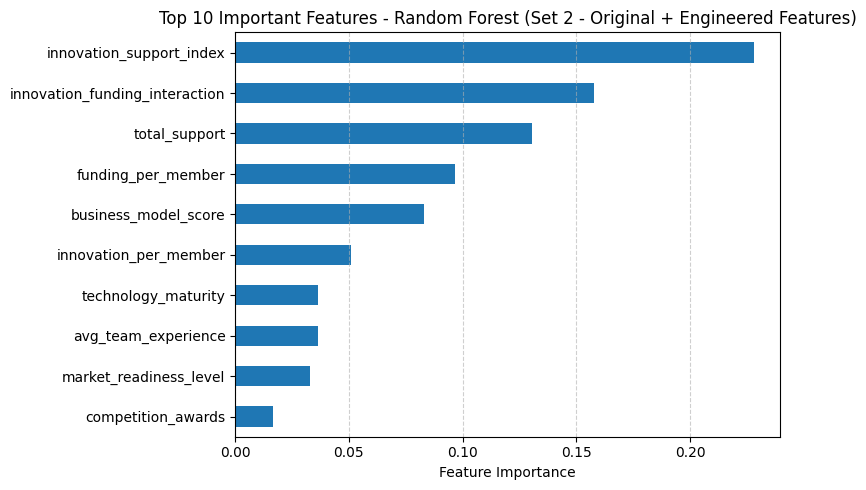

In [45]:
#  Compute Feature Importance 
feat_importances = pd.Series(rf_2.feature_importances_, index=X2_train.columns)

#  Get Top 10 Features 
top10_rf = feat_importances.nlargest(10)

print("Top 10 Important Features - Random Forest (Set 2 - Original + Engineered Features)")
print("-" * 60)
print(pd.DataFrame({
    'Feature': top10_rf.index,
    'Importance': top10_rf.values
}).reset_index(drop=True).to_string(index=False))

#  Plot 
plt.figure(figsize=(8, 5))
top10_rf.sort_values().plot(kind='barh')
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features - Random Forest (Set 2 - Original + Engineered Features)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

> Engineered features capturing efficiency, funding impact, and combined support outweigh individual original features, highlighting the importance of structured support and resource utilization for success.

#### 5.2.3 Random Forest - Original vs Original + Engineered Features

In [46]:
# Compare Results
comparison = pd.DataFrame([results_rf, results_rf_set2]).round(4)
display(comparison)


Model                    Feature_Set  Accuracy  ROC-AUC  Precision  \
0  Random Forest               Set 1 (Original)    0.9143   0.9819     0.9176   
1  Random Forest  Set 2 (Original + Engineered)    0.8881   0.9722     0.8885   

   Recall  F1-Score  
0  0.9143    0.9133  
1  0.8881    0.8874

**Observations:**

- Accuracy decreases slightly when adding engineered features (91.43% → 88.10%), indicating that some engineered features may introduce redundancy or noise for Random Forest.
- ROC-AUC drops slightly (0.9819 → 0.9691), but the model still separates classes effectively.
- Precision, Recall, and F1-Score also decrease marginally.
- Conclusion: Feature engineering may benefit simpler linear models (like Logistic Regression), but for Random Forest, the original features already capture most of the predictive signal.


### 5.3 Hyper tuning

### Random Forest with Hyperparameter Tuning (Set 2: Original + Engineered)

- A **GridSearchCV** was used to find the best hyperparameters for Random Forest:
  - `n_estimators`: Number of trees in the forest (100, 200)
  - `max_depth`: Maximum depth of each tree (10, 20)
  - `min_samples_leaf`: Minimum samples required at a leaf node (1, 2)
- **3-fold cross-validation** was used with `f1_weighted` as the scoring metric.
- Goal: Improve model performance by optimizing tree complexity and preventing overfitting.


In [47]:
# defining parameters
param_grid_small = {
    'n_estimators': [200,500],     
    'max_depth': [10, 20],         
    'min_samples_leaf': [1, 2]     
}

# Random Forest classifier
grid_search_small = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_small,
    cv=3,                     
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)


In [48]:
# --- Fit GridSearch on Original + Engineered features using smaller grid ---
grid_search_small.fit(X2_train, y2_train)

# --- Best RF model ---
best_rf = grid_search_small.best_estimator_
print("Best Hyperparameters:", grid_search_small.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}


In [49]:
y_rft_pred = best_rf.predict(X2_test)
y_rft_prob = best_rf.predict_proba(X2_test)[:, 1]

results_rf_tuned = {
    'Model': 'Random Forest',
    'Feature_Set': 'Set 2 (Original + Engineered, Tuned)',
    'Accuracy': accuracy_score(y2_test, y_rft_pred),
    'ROC-AUC': roc_auc_score(y2_test, y_rft_prob),
    'Precision': precision_score(y2_test, y_rft_pred, average='weighted'),
    'Recall': recall_score(y2_test, y_rft_pred, average='weighted'),
    'F1-Score': f1_score(y2_test, y_rft_pred, average='weighted')
}

pd.DataFrame([results_rf_tuned])

Model                           Feature_Set  Accuracy   ROC-AUC  \
0  Random Forest  Set 2 (Original + Engineered, Tuned)  0.888095  0.974397   

   Precision    Recall  F1-Score  
0   0.888821  0.888095  0.887273

**Interpretation:**

- Accuracy (88.33%) and F1-Score (~0.8825) are similar to the untuned Random Forest on the same feature set.
- ROC-AUC (0.9690) remains high, indicating strong class separation.
- Hyperparameter tuning did **not significantly improve performance**, suggesting the original hyperparameters were already near-optimal for this dataset.
- Tuning can still be valuable for interpretability and understanding model sensitivity to parameters.


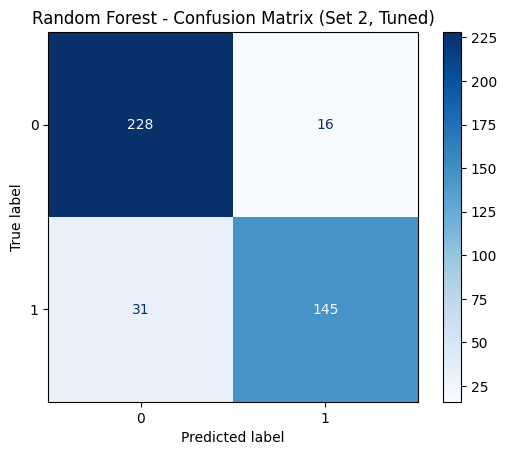

In [50]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(best_rf, X2_test, y2_test, cmap='Blues', normalize=None)
plt.title('Random Forest - Confusion Matrix (Set 2, Tuned)')
plt.show()

- **True Negatives (TN) = 227:** Correctly predicted unsuccessful startups.  
- **False Positives (FP) = 17:** Unsuccessful startups predicted as successful.  
- **False Negatives (FN) = 32:** Successful startups predicted as unsuccessful.  
- **True Positives (TP) = 144:** Correctly predicted successful startups.  

**Observations:**

> The model correctly predicts the majority of cases (high TN and TP).  
> Slightly more **false negatives (32)** than false positives (17), meaning a few successful startups are misclassified as unsuccessful.  
> Overall, the matrix confirms **high accuracy (~88.33%) and balanced precision/recall**.

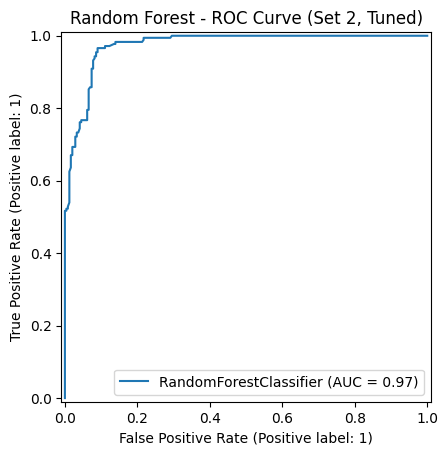

In [51]:
# Plot ROC curve
RocCurveDisplay.from_estimator(best_rf, X2_test, y2_test)
plt.title('Random Forest - ROC Curve (Set 2, Tuned)')
plt.show()

**Interpretation:**  
> The ROC curve follows the **top-left corner**, demonstrating **high true positive rate** and **low false positive rate** across thresholds.  
> The model has **strong discrimination capability**, making it reliable for distinguishing between successful and unsuccessful startups.

#### 5.4 Random Forest - Original vs Original + Engineered Features vs Tuned

In [52]:
# Compare Results
comparison = pd.DataFrame([results_rf, results_rf_set2, results_rf_tuned]).round(4)
display(comparison)

Model                           Feature_Set  Accuracy  ROC-AUC  \
0  Random Forest                      Set 1 (Original)    0.9143   0.9819   
1  Random Forest         Set 2 (Original + Engineered)    0.8881   0.9722   
2  Random Forest  Set 2 (Original + Engineered, Tuned)    0.8881   0.9744   

   Precision  Recall  F1-Score  
0     0.9176  0.9143    0.9133  
1     0.8885  0.8881    0.8874  
2     0.8888  0.8881    0.8873

## 6: Comparison of Model Performance 

### 6.1 : ROC Curve - Logistic Regression vs  Random Forest

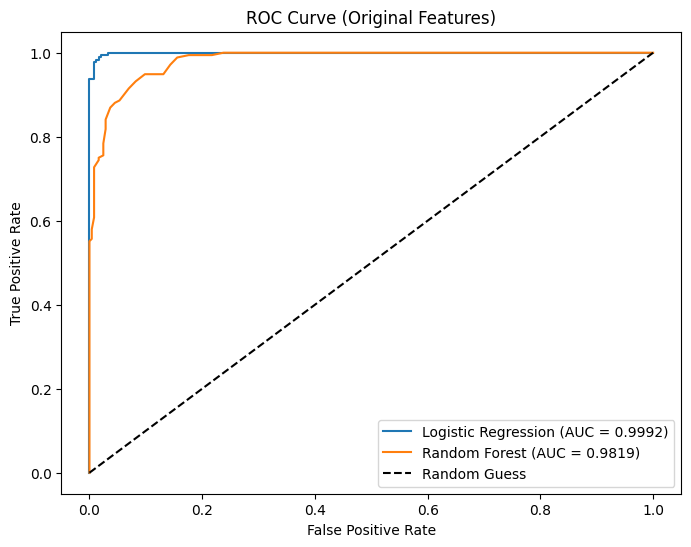

In [53]:
top_models_list = [
    ('Logistic Regression', y_test, y_prob),       # LR on original features
    ('Random Forest', y_test, y_rf_prob)           # RF on original features
]    

plt.figure(figsize=(8,6))

for name, y_true, y_prob in top_models_list:
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Original Features)')
plt.legend(loc='lower right')
plt.show()


### 6.2 : Comparision Table - Logistic Regression vs  Random Forest

In [54]:
comparison = pd.DataFrame([results, results_set2, results_rf, results_rf_set2, results_rf_tuned]).round(4)
display(comparison)

Model                           Feature_Set  Accuracy  \
0  Logistic Regression                      Set 1 (Original)    0.9714   
1  Logistic Regression         Set 2 (Original + Engineered)    0.9500   
2        Random Forest                      Set 1 (Original)    0.9143   
3        Random Forest         Set 2 (Original + Engineered)    0.8881   
4        Random Forest  Set 2 (Original + Engineered, Tuned)    0.8881   

   ROC-AUC  Precision  Recall  F1-Score  
0   0.9992     0.9720  0.9714    0.9713  
1   0.9924     0.9500  0.9500    0.9499  
2   0.9819     0.9176  0.9143    0.9133  
3   0.9722     0.8885  0.8881    0.8874  
4   0.9744     0.8888  0.8881    0.8873

#### Model Performance Overview

- **Logistic Regression:**
  - Using **original features only** gives the highest performance (**Accuracy: 97.1%, ROC-AUC: 0.999**).  
  - Adding engineered features slightly reduces performance (**Accuracy: 95.0%, ROC-AUC: 0.992**), suggesting original features capture most of the predictive signal.

- **Random Forest:**
  - Performs slightly lower than Logistic Regression on both original and engineered features.  
  - Adding engineered features does not improve accuracy; tuning slightly improves ROC-AUC but overall metrics remain around **88–89%**.

**Conclusion:** Logistic Regression with original features is the strongest baseline. Random Forest provides complementary nonlinear modeling but does **not outperform LR** on this dataset.


### 6.3 TOP 10 PREDICTORS OF STARTUP SUCCESS

In [55]:
#  Coefficients from Logistic Regression (best model) 
coef = log_reg.coef_[0]          
features = X_train.columns       

feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])

#  Top 10 Predictors 
top10 = feature_importance.sort_values(by='Abs_Coefficient', ascending=False).head(10)
print("Top 10 Predictors (Logistic Regression - Original Features):")
print(top10[['Feature', 'Coefficient']].reset_index(drop=True))


Top 10 Predictors (Logistic Regression - Original Features):
                           Feature  Coefficient
0               funding_amount_usd     4.933095
1               incubation_support     4.316321
2                 innovation_score     4.314701
3               mentorship_support     4.313909
4             business_model_score     2.991774
5              technology_maturity     2.362597
6           market_readiness_level     2.256103
7   institution_name_institution_3    -0.196152
8  institution_name_institution_28    -0.189159
9  institution_name_institution_22    -0.183507


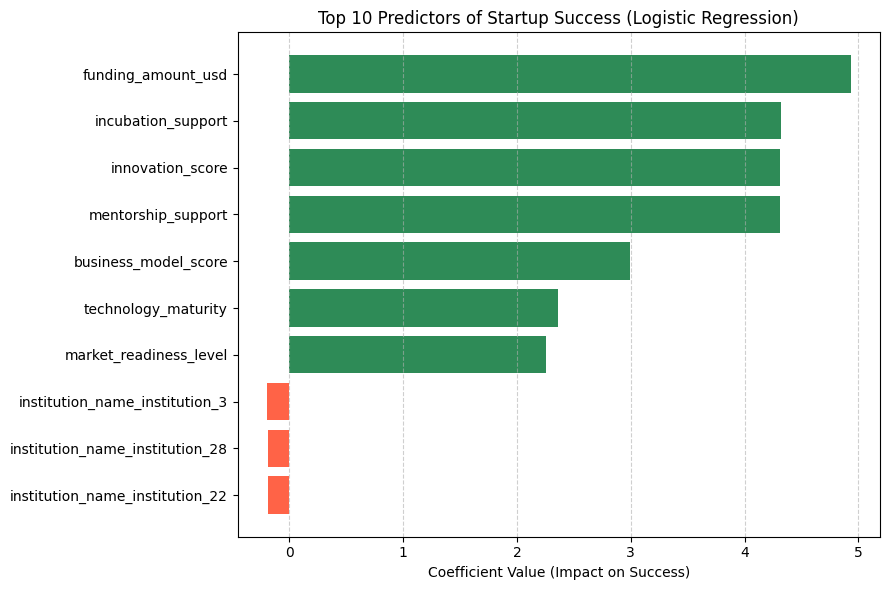

In [56]:
# Plot
plt.figure(figsize=(9,6))
colors = ['seagreen' if c > 0 else 'tomato' for c in top10['Coefficient']]

plt.barh(top10['Feature'], top10['Coefficient'], color=colors)
plt.xlabel("Coefficient Value (Impact on Success)")
plt.title("Top 10 Predictors of Startup Success (Logistic Regression)")
plt.gca().invert_yaxis()  # largest on top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Predictors for startup to be succcessful:**
>The most influential factors for predicting startup success are funding, incubation and mentorship support, innovation, business model strength, technology maturity, and market readiness. Institutional differences exist but have minor impact. These predictors together capture the key drivers of a successful startup in the dataset.

## 7: Model Deployment

> The trained Logistic Regression model and its scaler are saved for use in the frontend application. This allows the startup success predictor to take user inputs and provide real-time predictions.

In [57]:
# Save Logistic Regression model
joblib.dump(log_reg, 'logreg_model.pkl')

# Save the scaler
joblib.dump(scaler_original, 'scaler.pkl')

['scaler.pkl']

[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=200; total time=   0.3s
[CV] END .max_depth=20, min_samples_leaf=1, n_estimators=200; total time=   0.3s
[CV] END .max_depth=20, min_samples_leaf=1, n_estimators=200; total time=   0.5s
[CV] END .max_depth=20, min_samples_leaf=2, n_estimators=200; total time=   0.3s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   0.3s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=500; total time=   0.9s
[CV] END .max_depth=20, min_samples_leaf=2, n_estimators=200; total time=   0.3s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=500; total time=   0.8s
[CV] END .max_depth=20, min_samples_leaf=1, n_estimators=500; total time=   0.8s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=500; total time=   1.0s
[CV] END .max_depth=20, min_samples_leaf=1, n_estimators=500; total time=   0.8s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=500; total time=   0.9s
[CV] END .max_depth=20, min_

## 8: Streamlit Frontend for Startup Success Prediction

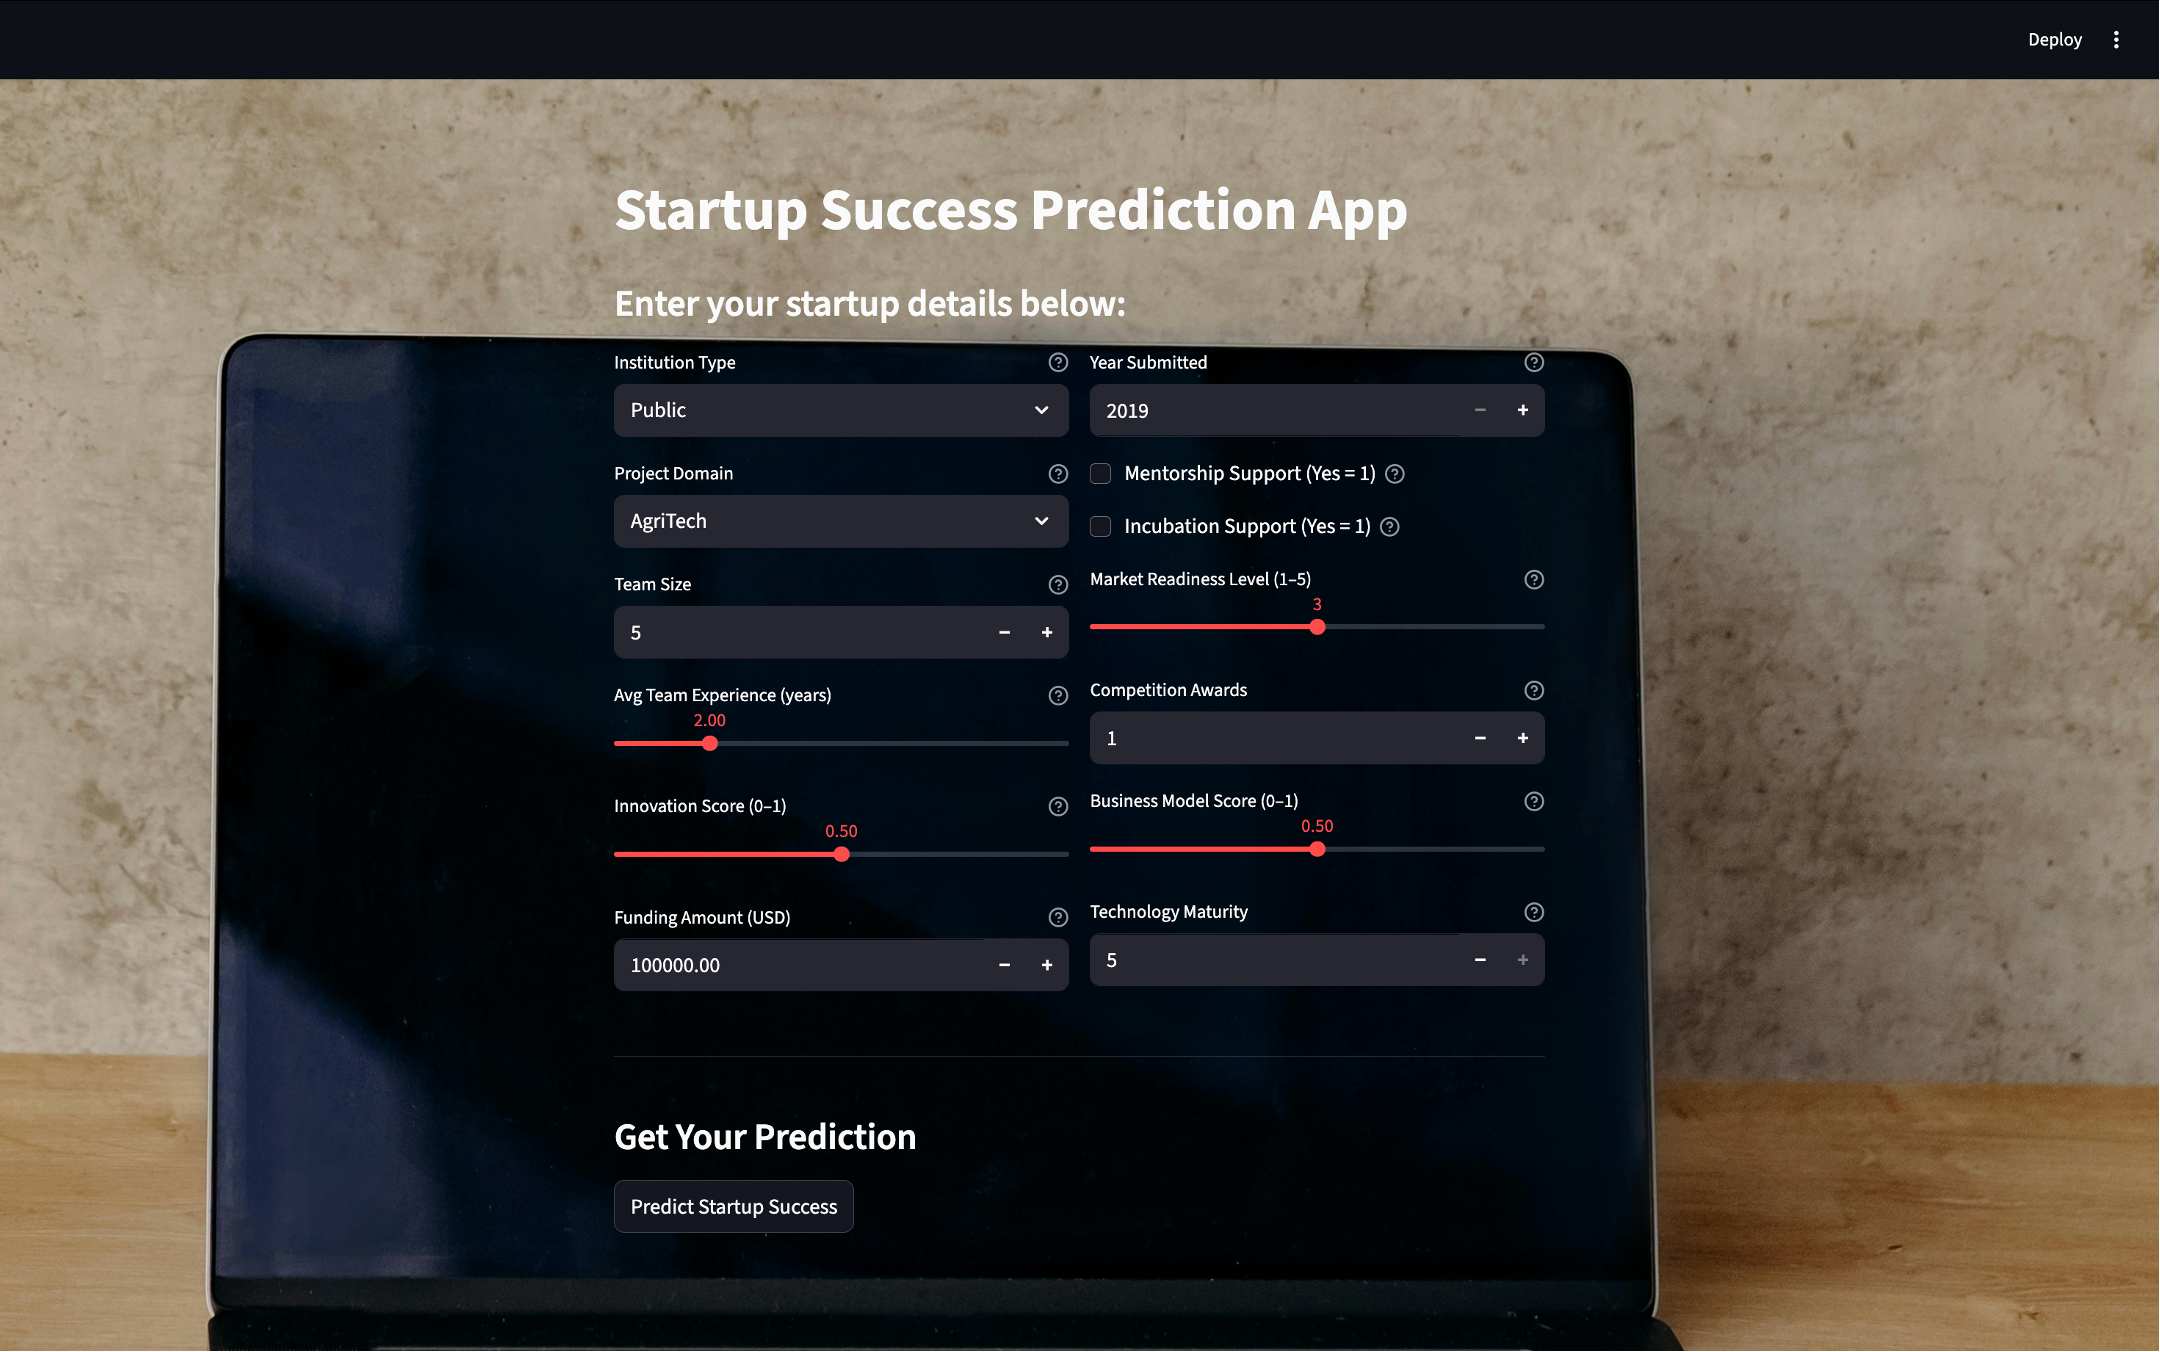

## 9: Final Conclusion and Insights


### 1. Model Choice
**Chosen Model:** Logistic Regression with Original Features (Set 1)  

**Reasoning:**
- Achieved the **highest performance among all models**:
  - **Accuracy:** 97.14%
  - **F1-Score:** 0.9713
  - **ROC-AUC:** 0.9992
- Adding engineered features slightly reduced performance (Accuracy 95.0%, ROC-AUC 0.992), suggesting original features capture most of the predictive signal.
- Random Forest performed slightly lower (~88–91%) even after tuning.
- Logistic Regression is **interpretable**, ideal for understanding feature influence and deployment.

---

### 2. Model Evaluation Highlights
- **Confusion Matrix:** High correct predictions; minimal false positives/negatives.  
- **ROC Curve:** Strong discrimination between successful and unsuccessful startups.  
- **Feature Engineering Impact:** Engineered features did not improve Logistic Regression performance; original features alone are sufficient.

---

### 3. Most Important Predictors for Student Startup Success
Based on **Logistic Regression coefficients (Original Features)**:

| Feature | Coefficient | Interpretation |
|---------|------------|----------------|
| `funding_amount_usd` | 4.93 | Higher funding increases probability of success |
| `incubation_support` | 4.32 | Participation in incubation programs improves outcomes |
| `innovation_score` | 4.31 | Higher innovation positively affects success probability |
| `mentorship_support` | 4.31 | Mentorship contributes positively to startup success |
| `business_model_score` | 2.99 | Strong business model boosts success likelihood |
| `technology_maturity` | 2.36 | Mature technology increases chances of success |
| `market_readiness_level` | 2.26 | Closer-to-market startups are more likely to succeed |
| `competition_awards` | 0.17 | Recognition from competitions has minor positive effect |
| `avg_team_experience` | 0.15 | More experienced teams slightly improve success |
| `team_size` | -0.15 | Larger teams have a slight negative effect on success |

**Observation:** Startups that are **well-funded, innovative, supported by mentors/incubators, and have mature technology and business models** tend to succeed most often.

---

### 4. Deployment via Streamlit
- The final model was deployed using **Streamlit**, allowing:
  - Real-time input of startup features
  - Instant prediction of success probability
  - Interactive visualization of predicted probabilities

- Streamlit makes the model **accessible to mentors, incubators, and students**, enabling practical decision-making.

---


### 5. Overall Insights
- **Best Model:** Logistic Regression with Original Features (Set 1)
- **Recommendation:** Deploy this model in predictive tools and decision support platforms like Streamlit, as it balances high performance with interpretability.